# Transformer

同学们好，在这个notebook中，我们将一步步实现self-attention算法和transformer的结构，同时复习Pytorch中的矩阵操作。

到目前为止，我们已经看到了循环神经网络（RNNs），它在序列到序列的任务上表现出色，但有两个主要缺点：（1）对于长序列，它们可能会出现梯度消失的问题；（2）由于隐藏状态之间的顺序依赖关系，它们可能需要很长时间来训练，这并未充分利用现代 GPU 的并行架构。第一个问题在一定程度上可以通过使用替代的 RNN 架构（如 LSTM、GRU）来解决，但第二个问题没有得到解决。

Transformer 在一定程度上解决了这些问题，它可以在训练期间并行处理输入，即使是长序列也能处理。在这个notebook中，我们将逐步实现 Transformer 模型，参考原始论文[Attention is all you need](https://arxiv.org/pdf/1706.03762.pdf)。我们还将使用一个AddSub数据集来解决一个向量到向量的问题。

在序列到序列的任务中，通常我们会同时使用编码器和解码器。在这次作业中，你将学习如何逐步实现基于编码器-解码器的 Transformer。我们将在这里实现一个更简单的版本，完成一个向量到向量的任务。这基本上意味着输入和输出序列的长度是**固定的**，我们不必担心输入序列的可变长度。

1. [**第一部分（准备工作）**](#第一部分：准备工作)：导入需要的包，运行项目中所需要的function
1. [**第二部分（实现 Transformer 模块）**](#第二部分：实现Transformer构建模块)：我们将学习如何实现 Transformer 的构建模块。它将包括以下模块：
   1. 多头注意力（MultiHeadAttention）
   2. 前馈网络（FeedForward）
   3. 层归一化（LayerNorm）
   4. 编码器块（Encoder Block）
   5. 解码器块（Decoder Block）
1. [**第三部分（数据加载）**](#第三部分：数据加载器)：我们将预处理一个AddSub数据集，其中包含输入算术表达式和表达式的输出结果。我们将使用位置编码（Positional Embedding）模块，同时我们将会构建数据加载器（DataLoader）。
1. [**第四部分（训练模型）**](#第四部分:在AddSub数据集上训练Transformer)：在最后一部分，我们将看看如何将实现的 Transformer 模型拟合到AddSub数据集上。

你可以在 CPU 上运行所有事情直到第3部分。第4部分需要 GPU，而在切换到此部分的运行时时，你还需要运行所有之前的部分，因为第4部分依赖于之前的部分。



# 第一部分：准备工作

请同学们运行一下block，导入所需要的包以及功能函数。

In [1]:
# 导入所需的包
import torch
import torch.nn.functional as F
from torch import Tensor
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
from IPython.display import Image
import math
import random
from tqdm import tqdm
import json
import seaborn
import os


# for plotting
%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # set default size of plots
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

我们将在第四部分使用GPU，前三个部分可以不开启GPU加速。
在第四部分，我们将使用 GPU 来加速我们的计算，运行此单元格以确保你正在使用 GPU。

我们将使用 `torch.float = torch.float32` 来表示数据，以及 `torch.long = torch.int64` 来表示标签。

请参阅 [torch.dtype](https://pytorch.org/docs/stable/tensor_attributes.html#torch-dtype) 了解有关数据类型的更多细节。

In [2]:
to_float = torch.float
to_long = torch.long

if torch.cuda.is_available():
    print("Good to go!")
    DEVICE = torch.device("cuda")
else:
    print("Please set GPU via Edit -> Notebook Settings.")
    DEVICE = torch.device("cpu")

Good to go!


项目中需要用到的一些function，请运行一下。

In [3]:
def reset_seed(number):
    """
    重置随机种子为指定的数字

    输入：
    - number：要使用的种子数
    """
    random.seed(number)
    torch.manual_seed(number)
    return

def rel_error(x, y, eps=1e-10):
    """
    这个函数用于计算两个张量 x 和 y 之间的相对误差。相对误差被定义为：
    
                            max_i |x_i - y_i]|
    rel_error(x, y) = -------------------------------
                      max_i |x_i| + max_i |y_i| + eps

    输入：
    - x，y：具有相同形状的张量
    - eps：用于数值稳定性的小正常数

    返回：
    - rel_error：给出 x 和 y 之间相对误差的标量
    """
    top = (x - y).abs().max().item()
    bot = (x.abs() + y.abs()).clamp(min=eps).max().item()
    return top / bot

# 第二部分：实现Transformer构建模块

在这一部分，我们将看到如何实现用于构建 Transformer 模型的各种模块。然后我们将使用这些模块来构建 Transformer 编码器和解码器，最终实现完整的 Transformer 模型。
每个模块都将被实现为 `nn.Module` 的子类；我们将使用 PyTorch 的自动微分来计算梯度，因此不需要手动实现反向传播。
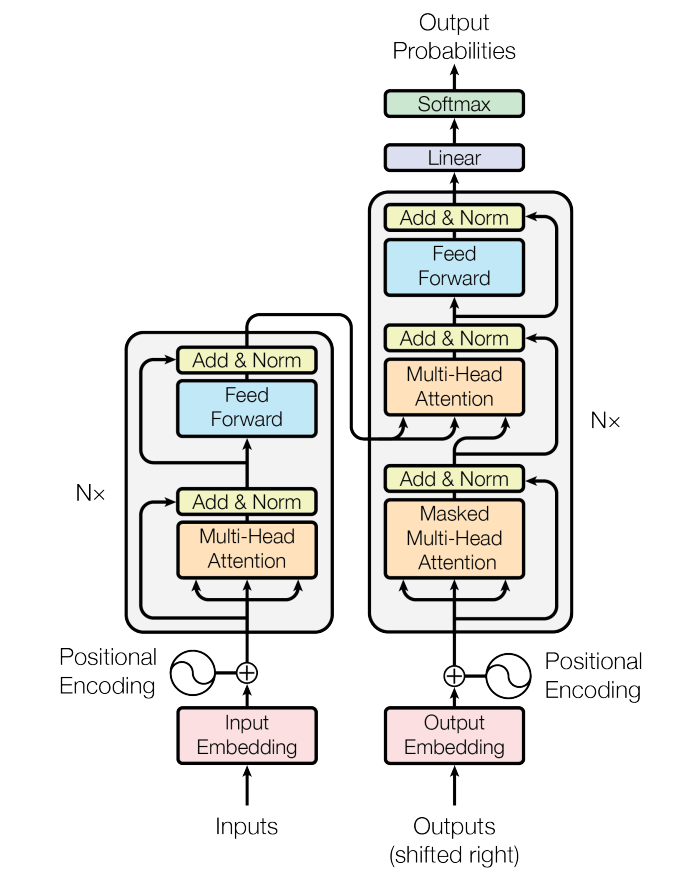

我们将按照原始论文的参考来实现以下模块：

1. 多头注意力（MultiHeadAttention）模块
2. 前馈网络（FeedForward）模块
3. 层归一化（Layer Normalization）
4. 位置编码（Positional Encoding）模块

然后，我们将使用这些构建模块，结合输入嵌入层，来构建 Transformer 编码器和解码器。我们将从实现多头注意力（MultiHeadAttention）、前馈网络（FeedForward）和层归一化（Layer Normalization）开始，稍后再看位置编码和输入嵌入。 

**注意：** 在实现这些模块时，所有这些模块的输入和输出张量的形状应该相同,可以通过检查检查输入和输出张量的形状判断代码补全是否正确。

## 多头注意力模块

Transformers是一种序列到序列的网络，它接收一个序列（例如英文句子）作为输入，输出一个序列（例如西班牙文句子）。输入序列首先被转换为嵌入向量，类似于我们在RNN部分讨论的内容，然后这些嵌入向量被传递到一个位置编码模块。接着，这些嵌入向量被转换为三个向量：查询（query）、键（key）和值（value），这个转换过程使用的是可学习的权重。然后我们使用一个Transformer编码器和解码器来得到最终的输出序列。

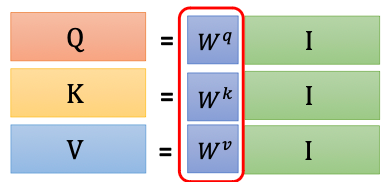

在这一部分，我们假设我们已经得到了查询、键和值向量(即我们需要处理的输入是如上图所示的$Q，K，V$)，并且我们将对它们进行处理。为了实现基本的多头注意力模块，我们首先将实现自注意力模块，然后从自注意力模块扩展到多头注意力模块。

### 自注意力模块

受到信息检索范式的启发，Transformers引入了查询、键和值(*query*、*key* 和*value*)的概念。在给定一个 *query* 的情况下，我们尝试从 *key*-*value* 对中提取信息。按照这些思路，我们通过对每个 *query* 计算 *key* 的加权和来数学上实现这一过程，其中权重由 *query* 和 *key* 的点积计算得到。更确切地说，对于每个 *query* ，我们计算其与所有 *key* 的点积，然后使用这些点积的标量输出作为权重，以找到 *values* 的加权和。请注意，在找到加权和之前，我们还会对权重向量应用 softmax 函数。我们将实现一个注意力模块，它接收查询、键和值向量作为输入，并返回一个张量，即值的加权和。

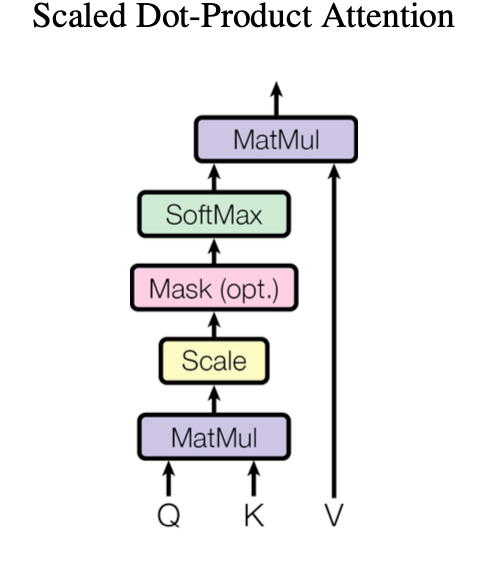




$$Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_k}})V$$

其中，$Q$、$K$ 和 $V$ 分别代表查询（Query）、键（Key）和值（Value）。这些都是通过对输入数据进行线性变换得到的。$d_k$ 是键向量的维度。

这个公式的含义是：

1. 计算查询和所有键的点积，得到一个得分。这个得分表示查询和每个键的匹配程度。

2. 除以 $\sqrt{d_k}$ 是进行scale操作。

3. 通过 softmax 函数，将得分转换为概率分布。这个概率分布表示模型在每个位置的“注意力”。

4. 最后，这个注意力分布和值向量相乘，得到最终的输出。这个输出是一个加权和，其中的权重就是注意力分布。




在这一部分中，你需要实现`scaled_dot_product_no_loop_batch`函数，请**不要用任何loop语句**。

可以参考使用:
1. [torch.bmm](https://pytorch.org/docs/stable/generated/torch.bmm.html)
2. [torch.softmax](https://pytorch.org/docs/stable/generated/torch.softmax.html)
3. [转置](https://pytorch.org/docs/stable/generated/torch.transpose.html)

#### 代码填空1: 实现注意力计算（10分）

In [4]:
def scaled_dot_product_no_loop_batch(
    query: Tensor, key: Tensor, value: Tensor, mask: Tensor = None
) -> Tensor:
    """
    该函数执行注意力机制的基本块，即缩放点积。我们将输入的 query、key 和 value 映射到输出。
    它使用矩阵-矩阵乘法来找到缩放权重，然后使用矩阵-矩阵乘法来找到最终输出。

    参数：
        query：形状为 (N,K, M) 的张量，其中 N 是批次大小，K 是序列长度，M 是序列嵌入维度
        key：形状为 (N, K, M) 的张量，其中 N 是批次大小，K 是序列长度，M 是序列嵌入维度
        value：形状为 (N, K, M) 的张量，其中 N 是批次大小，K 是序列长度，M 是序列嵌入维度
        mask：形状为 (N, K, K) 的布尔张量，用于掩盖计算加权和的权重

    返回：
        y：形状为 (N, K, M) 的张量，包含值的加权和
        weights_softmax：形状为 (N, K, K) 的张量，包含 softmax 后的权重矩阵。

    """
    _, _, M = query.shape
    #用bmm计算点积
    scores = torch.bmm(query, key.transpose(1, 2))
    scores /= torch.sqrt(torch.tensor(M, dtype=torch.float32))
    if mask is not None:
        scores = scores.masked_fill(mask, -1e9)
    #用softmax计算权重
    weights = torch.softmax(scores, dim=-1)
    y = torch.bmm(weights, value)
    return y, weights

#### 测试代码1: 测试注意力代码

In [5]:
N = 2  # 句子数量
K = 5  # 每个句子里的单词数
M = 4  # 每个单词embedding的特征维度

query = torch.linspace(-0.4, 0.6, steps=N * K * M).reshape(N, K, M)  # **to_double_cuda
key = torch.linspace(-0.8, 0.5, steps=N * K * M).reshape(N, K, M)  # **to_double_cuda
value = torch.linspace(-0.3, 0.8, steps=N * K * M).reshape(N, K, M)  # *to_double_cuda


y, _ = scaled_dot_product_no_loop_batch(query, key, value)

y_expected = torch.tensor(
    [
        [
            [-0.09603, -0.06782, -0.03962, -0.01141],
            [-0.08991, -0.06170, -0.03350, -0.00529],
            [-0.08376, -0.05556, -0.02735, 0.00085],
            [-0.07760, -0.04939, -0.02119, 0.00702],
            [-0.07143, -0.04322, -0.01502, 0.01319],
        ],
        [
            [0.49884, 0.52705, 0.55525, 0.58346],
            [0.50499, 0.53319, 0.56140, 0.58960],
            [0.51111, 0.53931, 0.56752, 0.59572],
            [0.51718, 0.54539, 0.57359, 0.60180],
            [0.52321, 0.55141, 0.57962, 0.60782],
        ],
    ]
).to(torch.float32)

if y.shape == y_expected.shape:
    print(f'Shapes of y and y_expected are the same')
else:
    print('Check the output shape of your funtion')
print("scaled_dot_product_no_loop_batch error: ", rel_error(y_expected, y))
if rel_error(y_expected, y) > 1e-5:
    print('There are some problems with your code, please check!')
else:
    print('The error is less than 1e-5. Done!')

# Error应该小于1e-5

Shapes of y and y_expected are the same
scaled_dot_product_no_loop_batch error:  4.020571992067902e-06
The error is less than 1e-5. Done!


### 观察时间复杂度：

Transformers 时间复杂度取决于输入序列的大小。
现在我们已经实现了 `self_attention_no_loop`，我们可以验证这一点。
运行下面的单元格：第一个具有长度为 256 的序列，第二个具有长度为 512 的序列。您应该会发现长度为 512 的情况大约慢 4 倍，从而显示出 Transformers 的复杂度随着序列长度的增加呈二次增长。
`%timeit` 行可能需要几秒钟才能运行。

In [6]:
N = 64
K = 256  
M = emb_size = 2048
dim_q = dim_k = 2048
query = torch.linspace(-0.4, 0.6, steps=N * K * M).reshape(N, K, M)  # **to_double_cuda
key = torch.linspace(-0.8, 0.5, steps=N * K * M).reshape(N, K, M)  # **to_double_cuda
value = torch.linspace(-0.3, 0.8, steps=N * K * M).reshape(N, K, M)  # *to_double_cuda

%timeit -n 5 -r 2  y = scaled_dot_product_no_loop_batch(query, key, value)

271 ms ± 37.5 ms per loop (mean ± std. dev. of 2 runs, 5 loops each)


In [7]:
N = 64
K = 512  
M = emb_size = 2048
dim_q = dim_k = 2048
query = torch.linspace(-0.4, 0.6, steps=N * K * M).reshape(N, K, M)  # **to_double_cuda
key = torch.linspace(-0.8, 0.5, steps=N * K * M).reshape(N, K, M)  # **to_double_cuda
value = torch.linspace(-0.3, 0.8, steps=N * K * M).reshape(N, K, M)  # *to_double_cuda

%timeit -n 5 -r 2  y = scaled_dot_product_no_loop_batch(query, key, value)

808 ms ± 58.4 ms per loop (mean ± std. dev. of 2 runs, 5 loops each)


#### 代码填空2: 自注意力层的实现（5分）

现在我们已经实现了 `scaled_dot_product_no_loop_batch`，让我们实现 `SingleHeadAttention`，它将作为 `MultiHeadAttention` 块的构建模块。对于这个练习，我们创建了一个 `SingleHeadAttention` 类，它继承自 PyTorch 的 `nn.module` 类。你需要 `forward` 函数。

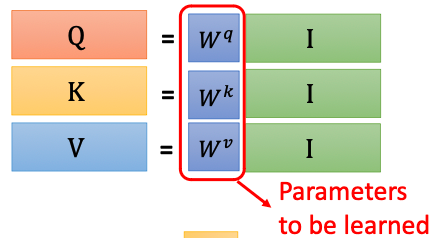

自注意力层中，我们初始化的三个linear层，即为上图所示的$W^q, W^k, W^v$权重。


In [8]:
class SelfAttention(nn.Module):
    def __init__(self, dim_in: int, dim_q: int, dim_v: int):
        super().__init__()

        """
        该类封装了自注意力层的实现。我们使用 MLP 层映射输入的查询、键和值，
        然后使用 scaled_dot_product_no_loop_batch 得到最终输出。

        参数：
            dim_in：输入序列嵌入维度的整数值
            dim_q：查询和键向量输出维度的整数值
            dim_v：值向量的输出维度的整数值

        """
        ##########################################################################
        # 初始化三个 nn.Linear 层，可以将输入维度为 dim_in 的输入转换为维度为 dim_q 的查询， #
        # 维度为 dim_q 的键，和维度为 dim_v 的值。                #
        ##########################################################################
        # 初始化q, k, v， 由于qk要进行点积计算，其维度需要保持一致
        self.q = nn.Linear(dim_in, dim_q)
        self.k = nn.Linear(dim_in, dim_q)
        self.v = nn.Linear(dim_in, dim_v)
        self.weights_softmax = None
        # 对于每个 Linear 层，使用以下策略初始化权重： #
        # 如果一个 Linear 层具有输入维度 D_in 和输出维度 D_out，则将权重初始化为从 [-c, c]  #
        # 范围内的均匀分布中抽取的值，其中 c = sqrt(6/(D_in + D_out))。   
        self.q.weight.data.uniform_(-math.sqrt(6/(dim_in+dim_q)), math.sqrt(6/(dim_in+dim_q)))
        self.k.weight.data.uniform_(-math.sqrt(6/(dim_in+dim_q)), math.sqrt(6/(dim_in+dim_q)))
        self.v.weight.data.uniform_(-math.sqrt(6/(dim_in+dim_v)), math.sqrt(6/(dim_in+dim_v)))

    def forward(
        self, query: Tensor, key: Tensor, value: Tensor, mask: Tensor = None
    ) -> Tensor:

        """
        该函数执行自注意力层的前向传播。

        参数：
            query：形状为 (N, K, M) 的张量
            key：形状为 (N, K, M) 的张量
            value：形状为 (N, K, M) 的张量
            mask：形状为 (N, K, K) 的张量
        返回：
            y：形状为 (N, K, dim_v) 的张量
        """
        ##########################################################################
        # TODO: 使用 init 函数中初始化的函数找到输出张量。确切地说，将输入 query、key 和 value #
        # 传递给上面初始化的三个函数。然后，将这三个转换后的 query、key 和 value 张量传递给 #
        # self_attention_no_loop_batch，以获得最终输出。只需将其作为 self_attention_no_loop_batch #
        # 中的一个变量传递。将 self_attention_no_loop_batch 的输出权重矩阵值赋给变量 self.weights_softmax。#
        ##########################################################################
        # TODO: 添加你的代码
        #直接得到Q,K,V
        Q = self.q(query)
        K = self.k(key)
        V = self.v(value)
        #点积
        y, self.weights_softmax = scaled_dot_product_no_loop_batch(Q, K, V, mask)

        return y


#### 测试代码2: 自注意力层的实现


In [9]:
reset_seed(0)
N = 2
K = 4
M = emb_size = 4
dim_q = dim_k = 4
atten_single = SelfAttention(emb_size, dim_q, dim_k)

for k, v in atten_single.named_parameters():
    # print(k, v.shape) 
    v.data.copy_(torch.linspace(-1.4, 1.3, steps=v.numel()).reshape(*v.shape))

query = torch.linspace(-0.4, 0.6, steps=N * K * M, requires_grad=True).reshape(
    N, K, M
)  
key = torch.linspace(-0.8, 0.5, steps=N * K * M, requires_grad=True).reshape(
    N, K, M
)  
value = torch.linspace(-0.3, 0.8, steps=N * K * M, requires_grad=True).reshape(
    N, K, M
)  

query.retain_grad()
key.retain_grad()
value.retain_grad()

y_expected = torch.tensor(
    [
        [
            [-1.10382, -0.37219, 0.35944, 1.09108],
            [-1.45792, -0.50067, 0.45658, 1.41384],
            [-1.74349, -0.60428, 0.53493, 1.67414],
            [-1.92584, -0.67044, 0.58495, 1.84035],
        ],
        [
            [-4.59671, -1.63952, 1.31767, 4.27486],
            [-4.65586, -1.66098, 1.33390, 4.32877],
            [-4.69005, -1.67339, 1.34328, 4.35994],
            [-4.71039, -1.68077, 1.34886, 4.37848],
        ],
    ]
)

dy_expected = torch.tensor(
    [
        [
            [-0.09084, -0.08961, -0.08838, -0.08715],
            [0.69305, 0.68366, 0.67426, 0.66487],
            [-0.88989, -0.87783, -0.86576, -0.85370],
            [0.25859, 0.25509, 0.25158, 0.24808],
        ],
        [
            [-0.05360, -0.05287, -0.05214, -0.05142],
            [0.11627, 0.11470, 0.11312, 0.11154],
            [-0.01048, -0.01034, -0.01019, -0.01005],
            [-0.03908, -0.03855, -0.03802, -0.03749],
        ],
    ]
)

y = atten_single(query, key, value)
dy = torch.randn(*y.shape)  

y.backward(dy)
query_grad = query.grad

print("SelfAttention error: ", rel_error(y_expected, y))
print("SelfAttention error: ", rel_error(dy_expected, query_grad))
if rel_error(y_expected, y) > 1e-5 and rel_error(dy_expected, query_grad) > 1e-5:
    print('There are some problems with your code, please check!')
else:
    print('The error is less than 1e-5. Done!')

SelfAttention error:  5.567700453666357e-07
SelfAttention error:  2.5410489503651006e-06
The error is less than 1e-5. Done!


#### 代码填空3: 多头注意力（10分）

我们已经实现了 `SingleHeadAttention` 块，这让我们非常接近实现 `MultiHeadAttention`。现在我们将看到，通过根据 Multi-Attention 块中的头数来操作输入张量的形状，可以实现这一点。我们设计了一个网络，该网络在相同的输入上使用多个 SingleHeadAttention 块来计算输出张量，并最终将它们连接起来生成单个输出。这不是实际使用的实现方式，因为它强制你初始化多个层，但我们在这里出于简单起见，使用 `SingleHeadAttention` 块实现 `MultiHeadAttention` 块。

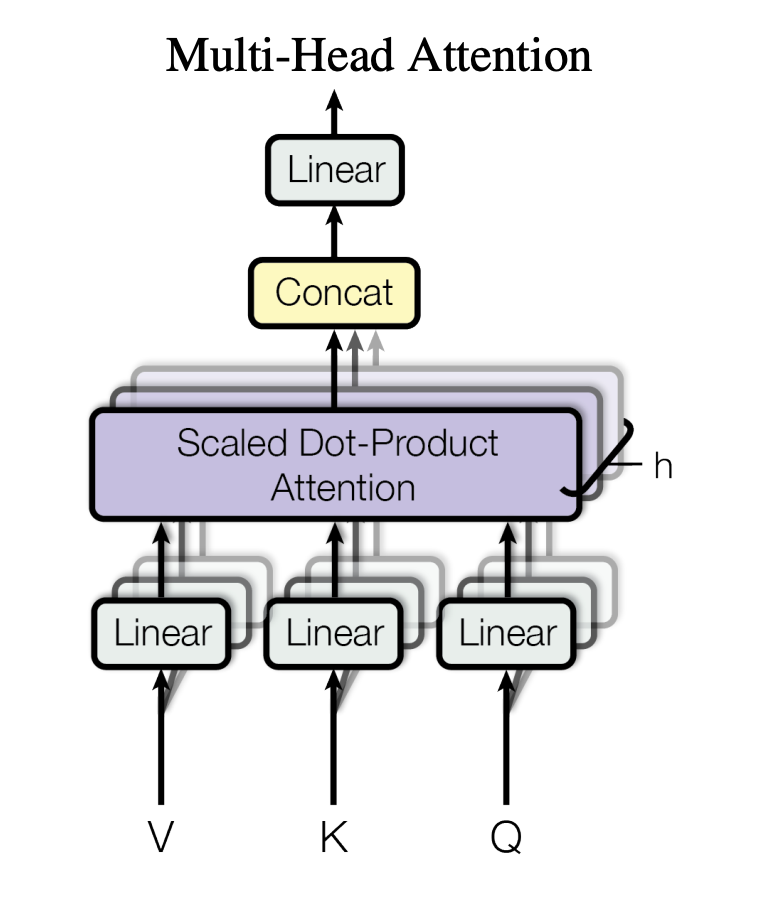



可以参考：
1. [nn.ModuleList](https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html)
2. [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)
3. [torch.cat](https://pytorch.org/docs/stable/generated/torch.cat.html#torch-cat)

In [10]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads: int, dim_in: int, dim_out: int):
        super().__init__()

        """
        
        一个简单的 Transformer 模型中 MultiheadAttention 层的实现。
        我们在相同的输入上并行使用多个 SelfAttention 层，然后将它们连接成单个张量。
        然后通过 MLP 将该张量传递以生成最终输出。
        输入形状将为 (N, K, M)，其中 N 是批量大小，K 是序列长度，M 是序列嵌入维度。
        参数：
            num_heads：指定头数的整数值
            dim_in：指定查询、键和值的输入维度的整数值。这将是每个 SingleHeadAttention 块的输入维度
            dim_out：指定完整 MultiHeadAttention 块的输出维度的整数值



        注意：在这里，当我们说维度时，我们指的是嵌入的维度。
              在 Transformers 中，输入是形状为 (N, K, M) 的张量，这里 N 是批量大小，K 是序列长度，
              而 M 是输入嵌入的大小。由于序列长度(K)和批量数(N)通常不会改变，我们通常只转换
              维度(M) 维度。
        """
        ##########################################################################
        # TODO: 在这里初始化两个东西：                                              #
        # 1.) 使用 nn.ModuleList 初始化一系列 SingleHeadAttention 层模块。          #
        #    这个列表的长度应该等于 num_heads，每个 SingleHeadAttention 层的输入维度为 dim_in， #
        #    查询、键和值的维度均为 dim_out。                                       #
        # 2.) 使用 nn.Linear 将 nn.Modulelist 块的输出映射回 dim_in。               #
        ##########################################################################
        self.heads = nn.ModuleList([SelfAttention(dim_in, dim_out, dim_out) for _ in range(num_heads)])
        self.linear = nn.Linear(num_heads * dim_out, dim_in)
        nn.init.uniform_(self.linear.weight, -torch.sqrt(torch.tensor(6. / (num_heads * dim_out + dim_in))), torch.sqrt(torch.tensor(6. / (num_heads * dim_out + dim_in))))# 权重初始化

    def forward(
        self, query: Tensor, key: Tensor, value: Tensor, mask: Tensor = None
    ) -> Tensor:

        """
        MultiHeadAttention 层的前向传播的实现。

        参数：
            query：形状为 (N, K, M) 的张量，其中 N 是批量中的序列数，
                K 是序列长度，M 是输入嵌入维度。M 应与初始化函数中的 dim_in 相等

            key：形状为 (N, K, M) 的张量，其中 N 是批量中的序列数，
                K 是序列长度，M 是输入嵌入维度。M 应与初始化函数中的 dim_in 相等

            value：形状为 (N, K, M) 的张量，其中 N 是批量中的序列数，
                K 是序列长度，M 是输入嵌入维度。M 应与初始化函数中的 dim_in 相等

            mask：形状为 (N, K, K) 的张量，其中 N 是批量中的序列数，
                K 是序列长度，M 是输入嵌入维度。M 应与初始化函数中的 dim_in 相等

        返回：
            y：形状为 (N, K, M) 的张量
        """
        y = None
        ##########################################################################
        # TODO: 使用初始化函数中定义的变量，通过 MultiHeadAttention 块进行前向传播。
        # nn.ModuleList 的行为类似一个列表，你可以使用 for 循环或列表解析来提取其中的不同元素。
        # nn.ModuleList 中的每个元素都是一个 SingleHeadAttention，它将使用相同的查询、键、值和掩码张量，
        # 并且你将得到一个张量列表作为输出。将这个张量列表连接起来，然后通过
        # nn.Linear 映射函数进行处理。                                        #
        ##########################################################################
        outputs = []
        for head in self.heads:    #对每个头进行操作
            output_head = head(query, key, value, mask)
            outputs.append(output_head)
        concat = torch.cat(outputs, dim=2)
        y = self.linear(concat)
        return y


#### 测试代码3: 多头注意力

In [11]:
reset_seed(0)
N = 2
num_heads = 2
K = 4
M = inp_emb_size = 4
out_emb_size = 8
atten_multihead = MultiHeadAttention(num_heads, inp_emb_size, out_emb_size)

for k, v in atten_multihead.named_parameters():
#     print(f'key of parameter:{k}, shape of its value:{v.shape}') 
    v.data.copy_(torch.linspace(-1.4, 1.3, steps=v.numel()).reshape(*v.shape))

query = torch.linspace(-0.4, 0.6, steps=N * K * M, requires_grad=True).reshape(
    N, K, M
)  
key = torch.linspace(-0.8, 0.5, steps=N * K * M, requires_grad=True).reshape(
    N, K, M
)  
value = torch.linspace(-0.3, 0.8, steps=N * K * M, requires_grad=True).reshape(
    N, K, M
)  

query.retain_grad()
key.retain_grad()
value.retain_grad()

y_expected = torch.tensor(
    [
        [
            [-0.23104, 0.50132, 1.23367, 1.96603],
            [0.68324, 1.17869, 1.67413, 2.16958],
            [1.40236, 1.71147, 2.02058, 2.32969],
            [1.77330, 1.98629, 2.19928, 2.41227],
        ],
        [
            [6.74946, 5.67302, 4.59659, 3.52015],
            [6.82813, 5.73131, 4.63449, 3.53767],
            [6.86686, 5.76001, 4.65315, 3.54630],
            [6.88665, 5.77466, 4.66268, 3.55070],
        ],
    ]
)
dy_expected = torch.tensor(
    [[[ 0.56268,  0.55889,  0.55510,  0.55131],
         [ 0.43286,  0.42994,  0.42702,  0.42411],
         [ 2.29865,  2.28316,  2.26767,  2.25218],
         [ 0.49172,  0.48841,  0.48509,  0.48178]],

        [[ 0.25083,  0.24914,  0.24745,  0.24576],
         [ 0.14949,  0.14849,  0.14748,  0.14647],
         [-0.03105, -0.03084, -0.03063, -0.03043],
         [-0.02082, -0.02068, -0.02054, -0.02040]]]
)

y = atten_multihead(query, key, value)
dy = torch.randn(*y.shape)  

y.backward(dy)
query_grad = query.grad
print("MultiHeadAttention error: ", rel_error(y_expected, y)) # error < 1e-5
print("MultiHeadAttention error: ", rel_error(dy_expected, query_grad)) # error < 1e-5
if rel_error(y_expected, y)> 1e-5 and rel_error(dy_expected, query_grad) > 1e-5:
    print('There are some problems with your code, please check!')
else:
    print('The error is less than 1e-5. Done!')

MultiHeadAttention error:  6.577880512731245e-07
MultiHeadAttention error:  1.0631412556891023e-06
The error is less than 1e-5. Done!


## LayerNormalization

我们在处理 CNN 时实现了 BatchNorm。BatchNorm 的一个问题是它依赖于完整的批次，当批次大小较小时可能会导致结果不佳。Ba 等人提出了 `LayerNormalization`，它考虑了这些问题，在序列到序列任务中已成为标准。在本节中，我们将实现 `LayerNormalization`。`LayerNormalization` 的另一个好处是，它依赖于序列的各个时间步骤或每个元素，因此可以并行化，并且测试时间的运行方式类似，因此在实现上更好。同样，您只需实现前向传播，而反向传播将由 Pytorch 自动求导来处理。在 `transformers.py` 中实现 `LayerNormalization` 类。可参考[LayerNorm](https://arxiv.org/abs/1607.06450)原理。


可参考：
1. [torch.mean](https://pytorch.org/docs/stable/generated/torch.mean.html#torch-mean)
2. [torch.sqrt](https://pytorch.org/docs/stable/generated/torch.sqrt.html#torch-sqrt)

#### 代码填空4: 层归一化（10分）

In [12]:
class LayerNormalization(nn.Module):
    def __init__(self, emb_dim: int, epsilon: float = 1e-10):
        super().__init__()
        """
        该类实现了 Transformers 中线性层的层归一化。与 BatchNorm 不同，它估计每个批次中的每个元素的归一化统计量，因此不依赖于完整的批次。
        输入形状类似 (N, K, M)，其中 N 是批次大小，K 是序列长度，M 是序列长度的嵌入。我们使用形状为 (N, K) 的均值和形状为 (N, K) 的标准差来归一化每个序列。

        参数:
            emb_dim: 表示嵌入维度的整数
            epsilon: 浮点数值

        """
        self.epsilon = epsilon
        self.gamma = nn.Parameter(torch.ones(emb_dim))
        self.beta = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x: Tensor):
        """
        层归一化层的前向传播的实现。

        参数:
            x: 形状为 (N, K, M) 或 (N, K) 的张量，其中 N 是批次大小，K 是序列长度，M 是嵌入维度

        返回:
            y: 在应用层归一化后的形状为 (N, K, M) 或 (N, K) 的张量

        """
        ##########################################################################
        # TODO: 实现层归一化层的前向传播。                                      #
        # 计算输入的均值和标准差，并使用它们对输入进行归一化。                       #
        # 进一步，使用 self.gamma 和 self.beta 来缩放和偏移这个归一化的输入。         #
        # 不要使用 torch.std 来计算标准差。                                      #
        ##########################################################################
        mean = x.mean(dim=-1, keepdim=True) #集散均值
        var = ((x - mean) ** 2).mean(dim=-1, keepdim=True) # 计算方差
        std = torch.sqrt(var + self.epsilon) # 计算标准差
        y = (x - mean) / std # 进行归一化
        return self.gamma * y + self.beta # 使用self.gamma和self.beta来缩放和偏移归一化的输入

#### 测试代码4: 层归一化

In [13]:
reset_seed(0)
N = 2
K = 4
norm = LayerNormalization(K)
inp = torch.linspace(-0.4, 0.6, steps=N * K, requires_grad=True).reshape(N, K)

inp.retain_grad()
y = norm(inp)

y_expected = torch.tensor(
    [[-1.34164, -0.44721, 0.44721, 1.34164], [-1.34164, -0.44721, 0.44721, 1.34164]]
)

dy_expected = torch.tensor(
    [[  5.70524,  -2.77289, -11.56993,   8.63758],
        [  2.26242,  -4.44330,   2.09933,   0.08154]]
)

dy = torch.randn(*y.shape)
y.backward(dy)
inp_grad = inp.grad

print("LayerNormalization error: ", rel_error(y_expected, y)) # error < 1e-5
print("LayerNormalization grad error: ", rel_error(dy_expected, inp_grad)) # error < 1e-5
if rel_error(y_expected, y)> 1e-5 and rel_error(dy_expected, inp_grad) > 1e-5:
    print('There are some problems with your code, please check!')
else:
    print('The error is less than 1e-5. Done!')

LayerNormalization error:  1.3772273765080196e-06
LayerNormalization grad error:  2.2087854796632033e-07
The error is less than 1e-5. Done!


## FeedForward Block

接下来，我们将实现 `Feedforward` 块。这些在 Transformer 的编码器和解码器网络中都会使用，它们由堆叠的 MLP 和 ReLU 层组成。在总体架构中，`MultiHeadAttention` 的输出被输入到 `FeedForward` 块中。在 `transformers.py` 中实现 `FeedForwardBlock`，并执行以下单元格以检查你的实现。可参考：[nn.ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)




In [14]:
class FeedForwardBlock(nn.Module):
    def __init__(self, inp_dim: int, hidden_dim_feedforward: int):
        super().__init__()
        """
        Transformers 中 FeedForward 块的实现。我们通过两个堆叠的 MLP 和一个 ReLU 层传递输入。
        前向传播具有以下架构:
        
        线性层 - ReLU - 线性层
        
        输入的形状将是 (N, K, M)，其中 N 是批量大小，K 是序列长度，M 是嵌入维度。
        
        参数:
            inp_dim: 输入张量的嵌入维度的整数表示
                     
            hidden_dim_feedforward: feedforward 块的隐藏维度
        """
        ##########################################################################
        # 在这里初始化两个 MLP，第一个使用 inp_dim 作为输入维度，hidden_dim_feedforward 作为输出，
        # 第二个使用 hidden_dim_feedforward 作为输入。使用 inp_dim 作为输出维度         
        ##########################################################################
        
        self.linear1 = nn.Linear(inp_dim, hidden_dim_feedforward)
        self.linear2 = nn.Linear(hidden_dim_feedforward, inp_dim)
        self.relu = nn.ReLU()

        nn.init.uniform_(self.linear1.weight, -torch.sqrt(torch.tensor(6. / (inp_dim + hidden_dim_feedforward))), torch.sqrt(torch.tensor(6. / (inp_dim + hidden_dim_feedforward))))
        nn.init.uniform_(self.linear2.weight, -torch.sqrt(torch.tensor(6. / (hidden_dim_feedforward + inp_dim))), torch.sqrt(torch.tensor(6. / (hidden_dim_feedforward + inp_dim))))

    def forward(self, x):
        """
        FeedForward 块的前向传播的实现。

        参数:
            x: 形状为 (N, K, M) 的张量，是 MultiHeadAttention 的输出
        返回:
            y: 形状为 (N, K, M) 的张量
            
        两个 MLP 层执行前向传播。在第一个 MLP 后使用 ReLU 层，
        在第二个 MLP 后不使用激活函数。
        结构： linear1 -> relu -> linear2
        """
        y = self.linear1(x)
        y = self.relu(y)
        y = self.linear2(y)

        return y


## Encoder 模块
现在，如果你回顾一下原始论文《Attention is all you Need》，那么我们几乎完成了 Transformer 的构建模块。剩下的是：

- 将构建模块封装成编码器块
- 将构建模块封装成解码器块
- 处理输入数据的预处理和位置编码。


我们首先来实现编码器块和解码器块。位置编码是一个非可学习的嵌入，我们可以将其视为 DataLoader 中的预处理步骤。

编码器块的输入是三个张量。我们假设我们有这三个张量，查询（query）、键（key）和值（value）。运行下面的单元格来检查你的 EncoderBlock 实现。你应该期望错误在 1e-5 以下。

#### 代码填空5: Encoder模块（10分）

In [15]:
class EncoderBlock(nn.Module):
    def __init__(
        self, num_heads: int, emb_dim: int, feedforward_dim: int, dropout: float
    ):
        super().__init__()
        """
        这个类实现了 Transformer 模型的编码器块。原始论文中使用了 6 个这样的块串行地训练了最终模型。
        在这里，我们首先使用已经实现的构建块初始化所需的层，然后最终编写前向传播过程，其中包括残差连接和 dropout。

        如论文中的图1所示，注意力就是你所需要的，
        编码器由四个组件组成:

        1. MultiHead Attention
        2. FeedForward 层
        3. 多头注意力和前馈层之后的残差连接
        4. LayerNorm

        架构如下:

       输入 - 多头注意力 - 输出1 - 层规范化(输出1 + 输入) - dropout - 输出2 \ 
        - 前馈 - 输出3 - 层规范化(输出3 + 输出2) - dropout - 输出

        这里，输入是多头注意力的输入，形状为 (N, K, M)，输出1、输出2 和输出3 是相应层的输出，
        我们将这些输出添加到它们各自的输入中以实现残差连接。

        参数:
            num_heads: int 值，指定编码器中 MultiHeadAttention 块的头数
            emb_dim: int 值，指定输入序列的嵌入维度
            feedforward_dim: int 值，指定 Transformer 的 FeedForward 层中的隐藏单元数
            dropout: float 值，指定 dropout 值
        """

        if emb_dim % num_heads != 0:
            raise ValueError(
                f"""嵌入维度 emb_dim = {emb_dim} 不能被
                             num_heads = {num_heads} 整除。请选择一个
                             合适的值。"""
            )

        ##########################################################################
        # 初始化以下层:                                                    #
        # 1. 一个 MultiHead Attention 块，使用 num_heads 作为头数和             #
        #    emb_dim 作为输入维度。您还应该能够计算 MultiheadHead 注意力的输出  #
        #    维度，给定 num_heads 和 emb_dim。                                    #
        #    提示: 使用的逻辑是在 MultiHead Attention 块内连接每个               #
        #    SingleHeadAttention 的输出，并选择输出维度，使得连接后的张量和    #
        #    输入张量具有相同的嵌入维度。                                       #
        #                                                                        #
        # 2. 两个输入维度等于 emb_dim 的 LayerNorm 层                          #
        # 3. 一个以 emb_dim 为输入，feedforward_dim 为隐藏单元的 FeedForward 块  #
        # 4. 一个具有给定 dropout 参数的 Dropout 层                             #
        ##########################################################################
        self.multihead_attention = MultiHeadAttention(num_heads, emb_dim, int(emb_dim // num_heads))
        self.layer_norm1 = LayerNormalization(emb_dim)
        self.dropout1 = nn.Dropout(dropout)

        self.feedforward = FeedForwardBlock(emb_dim, feedforward_dim)
        self.layer_norm2 = LayerNormalization(emb_dim)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):

        """
        Transformer 模型的 EncoderBlock 的前向传播的实现。
        参数:
            x: 形状为 (N, K, M) 的张量，作为输入序列
        返回:
            y: 形状为 (N, K, M) 的张量，作为前向传播的输出
         
       架构如下:

       输入 - 多头注意力 - 输出1 - 层规范化(输出1 + 输入) - dropout - 输出2 \ 
        - 前馈 - 输出3 - 层规范化(输出3 + 输出2) - dropout - 输出

        """
        
        y = None
        out1 = self.multihead_attention(x, x, x)
        # 残差并正则化
        out1 = self.layer_norm1(out1 + x)
        # Dropout
        out1 = self.dropout1(out1)

        # 前馈层
        out2 = self.feedforward(out1)
        # 残差并正则化
        out2 = self.layer_norm2(out2 + out1)
        # Dropout
        out2 = self.dropout2(out2)
        
        out3 = out2
        
        y = out3
        return y


#### 测试代码5：Encoder

In [16]:
reset_seed(0)
N = 2
num_heads = 2
emb_dim = K = 4
feedforward_dim = 8
M = inp_emb_size = 4
out_emb_size = 8
dropout = 0.2

enc_seq_inp = torch.linspace(-0.4, 0.6, steps=N * K * M, requires_grad=True).reshape(
    N, K, M
)

enc_block = EncoderBlock(num_heads, emb_dim, feedforward_dim, dropout)


for k, v in enc_block.named_parameters():
#     print(k, v.shape) 
    v.data.copy_(torch.linspace(-1.4, 1.3, steps=v.numel()).reshape(*v.shape))

encoder_out1_expected = torch.tensor(
    [[[ 0.00000, -0.31357,  0.69126,  0.00000],
         [ 0.42630, -0.25859,  0.72412,  3.87013],
         [ 0.00000, -0.31357,  0.69126,  3.89884],
         [ 0.47986, -0.30568,  0.69082,  3.90563]],

        [[ 0.00000, -0.31641,  0.69000,  3.89921],
         [ 0.47986, -0.30568,  0.69082,  3.90563],
         [ 0.47986, -0.30568,  0.69082,  3.90563],
         [ 0.51781, -0.30853,  0.71598,  3.85171]]]
)
encoder_out1 = enc_block(enc_seq_inp)
print("EncoderBlock error 1: ", rel_error(encoder_out1, encoder_out1_expected))



N = 2
num_heads = 1
emb_dim = K = 4
feedforward_dim = 8
M = inp_emb_size = 4
out_emb_size = 8
dropout = 0.2

enc_seq_inp = torch.linspace(-0.4, 0.6, steps=N * K * M, requires_grad=True).reshape(
    N, K, M
)  

enc_block = EncoderBlock(num_heads, emb_dim, feedforward_dim, dropout)

for k, v in enc_block.named_parameters():
    # print(k, v.shape) 
    v.data.copy_(torch.linspace(-1.4, 1.3, steps=v.numel()).reshape(*v.shape))

encoder_out2_expected = torch.tensor(
    [[[ 0.42630, -0.00000,  0.72412,  3.87013],
         [ 0.49614, -0.31357,  0.00000,  3.89884],
         [ 0.47986, -0.30568,  0.69082,  0.00000],
         [ 0.51654, -0.32455,  0.69035,  3.89216]],

        [[ 0.47986, -0.30568,  0.69082,  0.00000],
         [ 0.49614, -0.31357,  0.69126,  3.89884],
         [ 0.00000, -0.30354,  0.76272,  3.75311],
         [ 0.49614, -0.31357,  0.69126,  3.89884]]]
)
encoder_out2 = enc_block(enc_seq_inp)
print("EncoderBlock error 2: ", rel_error(encoder_out2, encoder_out2_expected))

EncoderBlock error 1:  5.951869338703975e-07
EncoderBlock error 2:  6.344433064213184e-07


## Decoder Block

现在，我们将看一下解码器的实现。对于更复杂的任务，如序列到序列的任务，我们需要一个解码器网络，它可以将编码器的输出转换为目标序列。这种架构在诸如语言翻译之类的任务中非常重要，其中我们有一个序列作为输入和一个序列作为输出。这个解码器从编码器获取输入和先前生成的值来生成下一个值。在训练过程中，我们在输入上使用掩码，以便解码器网络不能预先查看未来，在推理过程中，我们顺序处理数据。

在转到实现解码器块之前，我们应该注意"Masked MultiHead Attention"，实际上防止了解码器预测未来。让我们通过一个例子来理解这个。我们有一个表达式 `BOS POSITIVE 01 add POSITIVE 00 EOS`，即 `1+0`，它的输出是 `BOS POSITIVE 01 EOS`，即 `+1`。让我们关注输出序列。这是一个长度为5的序列（经过我们的预处理代码），将会转换成维度为$5\times128$的 *key*、*query* 和 *value* 矩阵，其中128是Transformer的嵌入维度。现在，在训练过程中，我们将这些向量输入到 `self_attention_no_loop_batch` 中而不使用掩码。它将计算 *query* 和 *key* 之间的点积，生成一个 $5\times5$ 的矩阵，其中第一行（形状为 $1\times5$）告诉我们单词 `EOS` 与 `EOS`、`POSITIVE`、`0`、`1` 和 `EOS` 之间的相关程度。这意味着它将使用所有这些标记的权重来学习最终要预测的序列。当我们训练模型时，这是可以接受的，但当我们进行推理时会发生什么呢？我们从一个全新的表达式开始，将这个表达式输入编码器，但这次我们只有解码器的第一个起始标记 `EOS`，我们不知道序列中的其他标记。因此，解决这个问题的方法是在函数 `self_attention_no_loop_batch` 中为解码器部分掩码权重。这种掩码应该防止解码器访问未来或下一个元素。

In [17]:
def get_subsequent_mask(seq):
    """
    解码器自注意力掩码的实现。在训练模型时，这将用于屏蔽目标序列。这里的输入形状是 (N, K)，其中 N 是批量大小，K 是序列长度。

    参数:
        seq: 形状为 (N, K) 的张量，其中 N 是批量大小，K 是序列长度
    返回:
        mask: 形状为 (N, K, K) 的张量，其中 N 是批量大小，K 是序列长度

    给定长度为 K 的序列，我们希望在函数 `self_attention_no_loop_batch` 中掩码权重，
    以防止解码器预测未来。
    """
    ###############################################################################
    # 这个函数构造了 Transformer 解码器部分的掩码。                         #
    # 要实现这一点，对于批量（N）中的每个序列（长度为 K），返回一个布尔矩阵，       #
    # 在应用掩码的地方为 True，不应用掩码的地方为 False。                         #                                                                           #
    ###############################################################################
    N, K = seq.shape
    ones_matrix = torch.ones((N, K, K), device=seq.device, dtype=torch.bool)
    mask = torch.triu(ones_matrix, diagonal=1)

    return mask


In [18]:
class DecoderBlock(nn.Module):
    def __init__(
        self, num_heads: int, emb_dim: int, feedforward_dim: int, dropout: float
    ):
        super().__init__()
        if emb_dim % num_heads != 0:
            raise ValueError(
                f"""The value emb_dim = {emb_dim} is not divisible
                             by num_heads = {num_heads}. Please select an
                             appropriate value."""
            )

        """
        该函数实现了Transformer模型的解码器块。
    
        args:
            num_heads: 表示头数的整数值

            emb_dim: 表示嵌入维度的整数值

            feedforward_dim: 表示前馈模型中的隐藏层的整数值

            dropout: 表示丢弃概率的浮点数值
        """
        ##########################################################################
        # 初始化以下层:                                                   #
        # 1. 两个具有 num_heads 个头数和 emb_dim 作为嵌入维度的MultiheadAttention 层。#
        #     与编码器一样，你应该能够确定两个MultiHeadAttention的输出维度。            #
        # 2. 一个FeedForward块，它将emb_dim作为输入维度，feedforward_dim作为隐藏层的维度 #
        # 3. 在每个块之后添加LayerNormalization层                                      #
        # 4. 在每个块之后添加丢弃层                                                    #
        ##########################################################################

        self.attention_self = MultiHeadAttention(num_heads, emb_dim, int(emb_dim/num_heads))
        self.attention_cross = MultiHeadAttention(num_heads, emb_dim, int(emb_dim/num_heads))

        self.feed_forward = FeedForwardBlock(emb_dim, feedforward_dim)

        self.norm1 = LayerNormalization(emb_dim)
        self.norm2 = LayerNormalization(emb_dim)
        self.norm3 = LayerNormalization(emb_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(
        self, dec_inp: Tensor, enc_inp: Tensor, mask: Tensor = None
    ) -> Tensor:

        """
        args:
            dec_inp: 形状为 (N, K, M) 的张量
            enc_inp: 形状为 (N, K, M) 的张量
            mask: 形状为 (N, K, K) 的张量

        此函数将处理解码器块的前向传递。它将输入 enc_inp 作为编码器输出，
        以及一个张量 dec_inp 作为目标序列，训练时目标序列将向后移动一个位置，
        推理时为一个初始标记 "BOS"。
        """
        ##########################################################################
        # 使用init函数中初始化的层，实现解码器块的前向传递。将 dec_inp 传递给  #
        # self.attention_self 层。这一层负责解码器输入的自我交互。                # 
        # 架构如下:
        
        # 输入 - 带有mask的多头注意力 - 输出1 - 层归一化(输入 + 输出1) - \
        # dp层 - (输出2和编码器输出) - 多头注意力 - 输出3 - \
        # 层归一化(输出3 + 输出2) - dp层 - 输出4 - 前馈网络 - 输出5 - \
        # 层归一化(输出5 + 输出4) - dp层 - 输出
        
        # 这里，输出1、输出2、输出3、输出4、输出5是各层对应的输出，编码器输出是编码器的输出，
        # 我们将这些输出添加到它们各自的输入中以实现残差连接。
        
        ##########################################################################
        out1 = self.attention_self(dec_inp, dec_inp, dec_inp, mask) # (N, K2, M)
        out2 = self.norm1(out1 + dec_inp) # (N, K2, M)
        out2 = self.dropout(out2) # (N, K2, M)
        out3 = self.attention_cross(out2, enc_inp, enc_inp) # query: out2, key&values: enc_inp
                                                            # out3: (N, K2, M)
        out4 = self.norm2(out3 + out2) # (N, K2, M)
        out4 = self.dropout(out4) # (N, K2, M)
        out5 = self.feed_forward(out4) # (N, K2, M)
        out = self.norm3(out5 + out4) # (N, K2, M)
        y = self.dropout(out) # (N, K2, M)
        return y


## 构建Transformer结构

Transformer的结构由N个encoder和decoder结构组成，以下代码将使用nn.ModuleList将N个编码器和解码器串联起来。

In [19]:
class Encoder(nn.Module):
    def __init__(
        self,
        num_heads: int,
        emb_dim: int,
        feedforward_dim: int,
        num_layers: int,
        dropout: float,
    ):
        """
        该类封装了使用多个EncoderBlock层的最终编码器的实现。

        args:
            num_heads: 表示EncoderBlock中要使用的头数的整数值
            emb_dim: 表示Transformer模型的嵌入维度的整数值
            feedforward_dim: 表示前馈块的隐藏层维度的整数值

        """

        super().__init__()
        self.layers = nn.ModuleList(
            [
                EncoderBlock(num_heads, emb_dim, feedforward_dim, dropout)
                for _ in range(num_layers)
            ]
        )

    def forward(self, src_seq: Tensor):
        for _layer in self.layers:
            src_seq = _layer(src_seq)

        return src_seq


class Decoder(nn.Module):
    def __init__(
        self,
        num_heads: int,
        emb_dim: int,
        feedforward_dim: int,
        num_layers: int,
        dropout: float,
        vocab_len: int,
    ):
        super().__init__()
        """
        解码器从编码器接收输入和目标序列，生成输出的最终序列。我们首先将输入通过堆叠的DecoderBlock，
        然后将输出投影到vocab_len，这是获取实际序列所需的。

        args:
            num_heads: 表示Transformer中MultiheadAttention的头数的整数
            emb_dim: 表示序列的嵌入维度的整数
            feedforward_dim: 表示前馈块中隐藏层的维度的整数
            num_layers: 表示解码器中DecoderBlock的数量的整数
            dropout: 表示每个DecoderBlock中的丢弃率的浮点数
            vocab_len: 词汇表的长度


        """

        self.layers = nn.ModuleList(
            [
                DecoderBlock(num_heads, emb_dim, feedforward_dim, dropout)
                for _ in range(num_layers)
            ]
        )
        self.proj_to_vocab = nn.Linear(emb_dim, vocab_len)
        a = (6 / (emb_dim + vocab_len)) ** 0.5
        nn.init.uniform_(self.proj_to_vocab.weight, -a, a)

    def forward(self, target_seq: Tensor, enc_out: Tensor, mask: Tensor):

        out = target_seq.clone()
        for _layer in self.layers:
            out = _layer(out, enc_out, mask)
        out = self.proj_to_vocab(out)
        return out

    


In [20]:
class Transformer(nn.Module):
    def __init__(
        self,
        num_heads: int,
        emb_dim: int,
        feedforward_dim: int,
        dropout: float,
        num_enc_layers: int,
        num_dec_layers: int,
        vocab_len: int,
    ):
        super().__init__()

        """
        该类实现了带有编码器和解码器的Transformer模型。模型的输入是形状为(N, K)的张量，
        输出是形状为(N*O, V)的张量。这里，N是批量大小，K是输入序列长度，O是输出序列长度，
        V是词汇表大小。输入通过共享的nn.Embedding层传递，然后加上输入位置编码。
        类似地，目标通过相同的nn.Embedding层传递，然后加上目标位置编码。唯一的区别是，
        我们在目标中取倒数第二个值。总结的输入（请查看代码了解详情）然后通过编码器和解码器
        块以获得最终输出。
        args:
            num_heads: 表示Encoder和Decoder中要使用的头数的整数
            emb_dim: 表示Transformer的嵌入维度的整数
            dim_feedforward: 表示Encoder和Decoder中隐藏层的数量的整数
            dropout: 表示丢弃层的概率的浮点数
            num_enc_layers: 表示编码器块的数量的整数
            num_dec_layers: 表示解码器块的数量的整数

        """
        self.emb_layer = None
        ##########################################################################
        # 初始化一个Embedding层，将vocab_len映射到emb_dim。这是我们模型的第一个输入，
        # 并将此输入转换为整个模型中保持不变的emb_dim。请使用self.emb_layer作为此层的名称。 #
        ##########################################################################
        self.emb_layer = nn.Embedding(vocab_len, emb_dim)
        self.encoder = Encoder(
            num_heads, emb_dim, feedforward_dim, num_enc_layers, dropout
        )
        self.decoder = Decoder(
            num_heads,
            emb_dim,
            feedforward_dim,
            num_dec_layers,
            dropout,
            vocab_len,
        )

    def forward(
        self, ques_b: Tensor, ques_pos: Tensor, ans_b: Tensor, ans_pos: Tensor
    ) -> Tensor:

        """

        实现Transformer的前向传递。

        args:
            ques_b: 形状为(N, K)的张量，包含算术表达式的输入序列
            ques_pos: 形状为(N, K, M)的张量，包含输入序列的位置编码
            ans_b: 形状为(N, K)的张量，包含算术表达式的目标序列
            ans_pos: 形状为(N, K, M)的张量，包含目标序列的位置编码

        返回:
            dec_out: 形状为(N*O, M)的张量，其中O是目标序列的大小。
        """
        q_emb = self.emb_layer(ques_b)
        a_emb = self.emb_layer(ans_b)
        q_emb_inp = q_emb + ques_pos
        a_emb_inp = a_emb[:, :-1] + ans_pos[:, :-1]
        dec_out = None
        ##########################################################################
        # 此部分包括编写完整Transformer的前向部分。首先，将q_emb_inp传递给编码器，
        # 这将是解码器输入之一。除了编码器输出外，还应构建一个适当的掩码，使用get_subsequent_mask。
        # 最后，将a_emb_inp、编码器输出和掩码传递给解码器。任务是屏蔽目标(a_emb_inp)的值。  #
        # 掩码形状将取决于张量ans_b                                      #
        ##########################################################################
        enc_out = self.encoder(q_emb_inp)
        mask = get_subsequent_mask(ans_b[:,:-1])
        dec_out = self.decoder(a_emb_inp, enc_out, mask)
        dec_out = dec_out.reshape(-1, dec_out.shape[2])

        return dec_out


# 第三部分：数据加载器

在这一部分中，我们将创建用于训练Transformer模型的最终数据加载器。这将包括两件事情：

- 实现位置编码（Positional Encoding）
- 使用我们在第一部分创建的`prepocess_input_sequence`函数创建一个数据加载器。

让我们开始实现输入的位置编码。位置编码使得Transformer在处理序列时能够感知位置信息。这些位置编码通常被添加到输入中，因此它们的形状应该与输入相同。由于位置编码不可学习，在训练过程中它们保持不变。因此，我们可以将其视为对输入进行的预处理步骤。我们的策略是实现位置编码函数，并在稍后创建玩具数据集的DataLoader时使用它。

### Sinusoid positional encoding

对于简单位置编码的一个主要缺点，那就是如果序列长度变大，两个连续位置编码之间的差异会变得越来越小，从而失去了位置感知的目的，因为连续位置之间的差异非常小。另一个问题是，对于每个位置，我们都沿着嵌入维度进行了复制，引入了冗余，这可能不会帮助网络学到任何新知识。可以使用不同的技巧来创建一个位置编码来解决这些问题。

让我们看一下更成熟的位置编码版本，它使用正弦和余弦函数的组合，也称为正弦波。这也是原始Transformer论文中使用的位置编码。对于序列（长度为 K）中的每个元素，具有位置 $p$ 和嵌入（维度 M）位置 $i$，我们可以将位置编码定义为：

$$PE_{(p, 2i)} = \sin\left(\frac{p}{10000^a}\right)$$
$$PE_{(p, 2i+1)} = \cos\left(\frac{p}{10000^a}\right)$$

$$\text{其中 }a = \left\lfloor{\frac{2i}{M}}\right\rfloor \text{，而 M 是Transformer的嵌入维度}$$

在这里，$p$ 对于序列中的位置保持不变，并且我们沿着嵌入维度交替分配正弦和余弦。


In [21]:
def position_encoding_sinusoid(K: int, M: int) -> Tensor:

    """
    正弦位置编码的实现。

    参数:
        K: 表示序列长度的整数
        M: 表示序列的嵌入维度的整数

    返回:
        y: 形状为 (1, K, M) 的张量
    """
    ##############################################################################
    # 给定输入序列长度 K 和嵌入维度 M，构造形状为 (K, M) 的张量，其中沿着     #
    # 维度的值遵循上面给出的方程。请注意在嵌入维度 M 上交替使用正弦和余弦。         #
    ##############################################################################
    y = torch.zeros(1, K, M)
    temp = torch.arange(M)
    temp = torch.div(temp, M, rounding_mode="floor").reshape(1, -1) #(1, M)
    p = torch.arange(K).unsqueeze(dim=-1)
    """
    temp:我们得到的是从 0 到 1 之间的均匀间隔的值。
    接下来，我们创建一个形状为 (K, 1) 的张量 num，其中包含从 0 到 K-1 的整数，并在最后一个维度上增加一个维度。
    """
    y[0, :, 0::2] = torch.sin(p / torch.pow(10000, temp[0, 0::2]))
    y[0, :, 1::2] = torch.cos(p / torch.pow(10000, temp[0, 1::2]))
    return y


### 加载数据

由于Transformer在序列到序列任务上表现非常好，我们将在一个算术操作的玩具任务上实现它。我们将使用Transformer模型来执行两个整数的加法和减法，其中整数的绝对值最多为50。一个简单的例子是使用Transformer模型执行 `-5 + 2` 的计算，并得到正确的结果 `-3`。由于解决这个问题可以有多种方法，我们将看到如何将其作为序列到序列问题提出，并使用Transformer模型解决它。
让我们先看一下数据：

In [22]:
train_data_path = '/kaggle/input/hw-transformer-addsub/train_data.json'
val_data_path = '/kaggle/input/hw-transformer-addsub/val_data.json'
test_data_path = '/kaggle/input/hw-transformer-addsub/test_data.json'

train_data = json.load(open(train_data_path))
val_data = json.load(open(val_data_path))
test_data = json.load(open(test_data_path))

In [23]:
num_examples = 4
for q, a in zip(
    train_data["inp_expression"][:num_examples], 
    train_data["out_expression"][:num_examples]
    ):
  print("Expression: " + q + " Output: " + a)

Expression: BOS POSITIVE 17 add NEGATIVE 49 EOS Output: BOS NEGATIVE 32 EOS
Expression: BOS POSITIVE 30 add POSITIVE 01 EOS Output: BOS POSITIVE 31 EOS
Expression: BOS POSITIVE 21 subtract NEGATIVE 43 EOS Output: BOS POSITIVE 64 EOS
Expression: BOS NEGATIVE 22 subtract NEGATIVE 44 EOS Output: BOS POSITIVE 22 EOS


## 这些示例代表什么意思：

让我们首先看一下这里的第一个和第三个示例，并理解它们代表了什么：

- 表达式：`BOS NEGATIVE 30 subtract NEGATIVE 34 EOS` 输出：`BOS POSITIVE 04 EOS`：这里的表达式是 $(-30) - (-34)$。这里符号 `+` 有两个含义：一个是表示数字的符号，另一个是两个整数之间的加法操作。为了简化神经网络的问题，我们用不同的文本标记表示它们。$(-30) - (-34)$ 的输出是 $+4$。这里的 `BOS` 和 `EOS` 分别指示序列的开头和结尾。
- 同样，第二个表达式，`BOS NEGATIVE 34 add NEGATIVE 15 EOS` 输出：`BOS NEGATIVE 49 EOS` 意味着我们正在进行计算 $(-34) + (-15)$。与上面类似，这里的符号 `-` 表示两个东西：第一个是整数的符号，第二个是两个整数之间的操作。同样，我们用不同的标记表示，以简化神经网络的问题。这里的输出是 -49。这里的 `BOS` 和 `EOS` 分别指示序列的开头和结尾。

现在我们对数据有了一定的了解，让我们开始对数据进行预处理，因为神经网络无法理解字符串，我们需要将它们表示为数字。

## 预处理数据
我们需要将原始输入序列转换为可以用神经网络处理的格式。
具体来说，我们需要将一个人类可读的字符串（例如 `BOS NEGATIVE 30 subtract NEGATIVE 34 EOS`）转换为一系列**标记**，其中每个标记将是一个整数。
将输入字符串转换为一系列标记的过程称为**标记化**。

在我们可以对任何特定序列进行标记化之前，我们首先需要构建一个**词汇表**；这是一个包含数据集中所有标记的详尽列表，并且从每个标记到一个唯一整数值的映射。
在我们的例子中，我们的词汇表将包含16个元素：一个条目表示每个数字 `0` 到 `9`，两个标记用于表示数字的符号（`POSITIVE` 和 `NEGATIVE`），两个标记表示加法和减法运算（`add` 和 `subtract`），最后两个特殊标记表示序列的开头和结尾（`BOS`，`EOS`）。

我们通常使用一对数据结构来表示词汇表。
第一个是所有字符串标记的列表（下面的 `vocab`），使得 `vocab[i] = s` 意味着字符串 `s` 被分配了整数值 `i`。这使我们能够查找与任何数值索引 `i` 关联的字符串。
我们还需要一个数据结构，使我们能够反向映射：给定一个字符串 `s`，找到它分配的索引 `i`。通常，这表示为一个哈希映射（Python中的 `dict` 对象），其键是字符串，其值是分配给这些字符串的索引。
您将实现函数 `generate_token_dict`，该函数输入列表 `vocab` 并返回给定此映射的字典 `convert_str_to_token`。

一旦您构建了词汇表，然后您可以实现函数 `preprocess_input_sequence`，它使用词汇表数据结构将输入字符串转换为整数标记列表。

In [24]:
SPECIAL_TOKENS = ["POSITIVE", "NEGATIVE", "add", "subtract", "BOS", "EOS"]
vocab = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"] + SPECIAL_TOKENS

In [25]:
def generate_token_dict(vocab):
    """
    该函数从词汇表中的元素创建一个哈希映射，将其映射到唯一的正整数值。

    参数:
        - vocab: 这是一个包含词汇表中所有项目的字符串的一维列表

    返回值:
        - token_dict: 一个Python字典，键是词汇表中的字符串项，值是唯一的整数值
    """

    ##############################################################################                             #
    # 使用此函数为词汇表列表中的每个元素分配一个唯一的整数元素。
    #  将词汇表中的第一个元素映射为0，将词汇表中的最后一个元素映射为len(vocab)，
    #  并将中间的元素映射为连续的数字。
    ##############################################################################
    token_dict = {}
    for idx, item in enumerate(vocab):
      token_dict[item] = idx
    return token_dict


In [26]:
def prepocess_input_sequence(
    input_str: str, token_dict: dict, spc_tokens: list
) -> list:
    """
    该函数的目标是将输入字符串转换为一系列正整数，以便我们能够进一步使用神经网络处理该字符串。我们将使用上一个函数中生成的字典将字符串中的元素映射到唯一的值。
    请注意，我们为输入序列中的每个整数分配一个值。例如，对于输入序列中存在的数字 "33"，您应该将其拆分为数字列表，['0', '3']，并将其分配给token_dict中相应的值。

    参数:
    - input_str: 输入数据中的单个字符串
               例如: "BOS POSITIVE 0333 add POSITIVE 0696 EOS"
    - token_dict: 令牌字典，其键为字符串中的元素，值为唯一的正整数。这是使用 generate_token_dict 函数生成的
    - spc_tokens: 除了数字以外的特殊令牌。
    返回值:
    - out_tokens: 与输入字符串对应的整数列表

    """
    out = []
    ##############################################################################
    # 对于输入序列中的每个数字，将其拆分为数字列表，并使用该数字列表从token_dict中分配适当的值。
    # 对于输入字符串中存在的特殊令牌，为完整的令牌分配适当的值。
    ##############################################################################
    for item in input_str.split():
      if item in spc_tokens:
        out.append(token_dict[item])

      else:
        for digit in item:
          out.append(token_dict[digit])
    return out


In [27]:
convert_str_to_tokens = generate_token_dict(vocab)

ex1_in = "BOS POSITIVE 0333 add POSITIVE 0696 EOS"
ex2_in = "BOS POSITIVE 0673 add POSITIVE 0675 EOS"
ex3_in = "BOS NEGATIVE 0286 subtract NEGATIVE 0044 EOS"
ex4_in = "BOS NEGATIVE 0420 add POSITIVE 0342 EOS"

ex1_out = "BOS POSITIVE 1029 EOS"
ex2_out = "BOS POSITIVE 1348 EOS"
ex3_out = "BOS NEGATIVE 0242 EOS"
ex4_out = "BOS NEGATIVE 0078 EOS"

ex1_inp_preprocessed = torch.tensor(
    prepocess_input_sequence(ex1_in, convert_str_to_tokens, SPECIAL_TOKENS)
)
ex2_inp_preprocessed = torch.tensor(
    prepocess_input_sequence(ex2_in, convert_str_to_tokens, SPECIAL_TOKENS)
)
ex3_inp_preprocessed = torch.tensor(
    prepocess_input_sequence(ex3_in, convert_str_to_tokens, SPECIAL_TOKENS)
)
ex4_inp_preprocessed = torch.tensor(
    prepocess_input_sequence(ex4_in, convert_str_to_tokens, SPECIAL_TOKENS)
)

ex1_processed_expected = torch.tensor([14, 10, 0, 3, 3, 3, 12, 10, 0, 6, 9, 6, 15])
ex2_processed_expected = torch.tensor([14, 10, 0, 6, 7, 3, 12, 10, 0, 6, 7, 5, 15])
ex3_processed_expected = torch.tensor([14, 11, 0, 2, 8, 6, 13, 11, 0, 0, 4, 4, 15])
ex4_processed_expected = torch.tensor([14, 11, 0, 4, 2, 0, 12, 10, 0, 3, 4, 2, 15])

ex1_out = torch.tensor(
    prepocess_input_sequence(ex1_out, convert_str_to_tokens, SPECIAL_TOKENS)
)
ex2_out = torch.tensor(
    prepocess_input_sequence(ex2_out, convert_str_to_tokens, SPECIAL_TOKENS)
)
ex3_out = torch.tensor(
    prepocess_input_sequence(ex3_out, convert_str_to_tokens, SPECIAL_TOKENS)
)
ex4_out = torch.tensor(
    prepocess_input_sequence(ex4_out, convert_str_to_tokens, SPECIAL_TOKENS)
)

ex1_out_expected = torch.tensor([14, 10, 1, 0, 2, 9, 15])
ex2_out_expected = torch.tensor([14, 10, 1, 3, 4, 8, 15])
ex3_out_expected = torch.tensor([14, 11, 0, 2, 4, 2, 15])
ex4_out_expected = torch.tensor([14, 11, 0, 0, 7, 8, 15])

print(
    "preprocess input token error 1: ",
    rel_error(ex1_processed_expected, ex1_inp_preprocessed),
)
print(
    "preprocess input token error 2: ",
    rel_error(ex2_processed_expected, ex2_inp_preprocessed),
)
print(
    "preprocess input token error 3: ",
    rel_error(ex3_processed_expected, ex3_inp_preprocessed),
)
print(
    "preprocess input token error 4: ",
    rel_error(ex4_processed_expected, ex4_inp_preprocessed),
)
print("\n")
print("preprocess output token error 1: ", rel_error(ex1_out_expected, ex1_out))
print("preprocess output token error 2: ", rel_error(ex2_out_expected, ex2_out))
print("preprocess output token error 3: ", rel_error(ex3_out_expected, ex3_out))
print("preprocess output token error 4: ", rel_error(ex4_out_expected, ex4_out))
# 所有error都应该为0

preprocess input token error 1:  0.0
preprocess input token error 2:  0.0
preprocess input token error 3:  0.0
preprocess input token error 4:  0.0


preprocess output token error 1:  0.0
preprocess output token error 2:  0.0
preprocess output token error 3:  0.0
preprocess output token error 4:  0.0


### 构建DataLoader

现在，我们将使用实现的位置编码来构建一个PyTorch中的数据加载器。数据加载器的作用是为训练/验证返回一个批次。我们首先创建一个Dataset类，该类为我们提供批次中的单个元素，然后使用DataLoader来封装数据集。我们从`torch.utils.data.Dataset`类继承Dataset。这个类包含两个重要的函数，根据你的用例,你会更改这些函数。第一个函数是`__init__`，这包含了*静态*的组件，换句话说，当我们从完整数据中获取下一个元素时，这些变量不会改变。第二个函数是`__getitem__`，它包含最终数据加载器的核心功能。

要获取最终的数据加载器，我们将`train_data`和`test_data`包装在`torch.utils.data.DataLoader`类中。


In [28]:
class AddSubDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        input_seqs,
        target_seqs,
        convert_str_to_tokens,
        special_tokens,
        emb_dim,
        pos_encode,
    ):

        """
       该类实现了将用于玩具数据集的数据加载器。

        参数:
        - `input_seqs`: 输入字符串列表
        - `target_seqs`: 输出字符串列表
        - `convert_str_to_tokens`: 将输入字符串转换为标记的字典
        - `special_tokens`: 特殊字符串列表
        - `emb_dim`: Transformer的嵌入维度
        - `pos_encode`: 用于计算数据的位置编码的函数
        """

        self.input_seqs = input_seqs
        self.target_seqs = target_seqs
        self.convert_str_to_tokens = convert_str_to_tokens
        self.emb_dim = emb_dim
        self.special_tokens = special_tokens
        self.pos_encode = pos_encode

    def preprocess(self, inp):
        return prepocess_input_sequence(
            inp, self.convert_str_to_tokens, self.special_tokens
        )

    def __getitem__(self, idx):
        """
        获取数据中索引为idx的元素的核心函数。
        参数：
        - `idx`：需要从数据中提取的元素的索引
        返回：
        - `preprocess_inp`：长度为K的一维张量，其中K是输入序列的长度
        - `inp_pos_enc`：形状为(K, M)的张量，其中K是序列长度，M是嵌入维度
        - `preprocess_out`：长度为O的一维张量，其中O是输出序列的长度
        - `out_pos_enc`：形状为(O, M)的张量，其中O是序列长度，M是嵌入维度
        """

        inp = self.input_seqs[idx]
        out = self.target_seqs[idx]
        preprocess_inp = torch.tensor(self.preprocess(inp))
        preprocess_out = torch.tensor(self.preprocess(out))
        inp_pos = len(preprocess_inp)
        inp_pos_enc = self.pos_encode(inp_pos, self.emb_dim)
        out_pos = len(preprocess_out)
        out_pos_enc = self.pos_encode(out_pos, self.emb_dim)

        return preprocess_inp, inp_pos_enc[0], preprocess_out, out_pos_enc[0]

    def __len__(self):
        return len(self.input_seqs)

In [29]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
setup_seed(2024)

BATCH_SIZE = 16

X_train, y_train = train_data["inp_expression"], train_data["out_expression"]
X_val, y_val = val_data["inp_expression"], val_data["out_expression"]
X_test, y_test = test_data["inp_expression"], test_data["out_expression"]

train_data = AddSubDataset(
    X_train,
    y_train,
    convert_str_to_tokens,
    SPECIAL_TOKENS,
    32,
    position_encoding_sinusoid
    
)
valid_data = AddSubDataset(
    X_val, y_val, convert_str_to_tokens, SPECIAL_TOKENS, 32, position_encoding_sinusoid
)
test_data = valid_data = AddSubDataset(
    X_test, y_test, convert_str_to_tokens, SPECIAL_TOKENS, 32, position_encoding_sinusoid
)


train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True
)
valid_loader = torch.utils.data.DataLoader(
    valid_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True
)

In [30]:
import torch.optim as optim

inp_seq_len = 9
out_seq_len = 5
num_heads = 4
emb_dim = 32
dim_feedforward = 64
dropout = 0.2
num_enc_layers = 4
num_dec_layers = 4
vocab_len = len(vocab)

model = Transformer(
    num_heads,
    emb_dim,
    dim_feedforward,
    dropout,
    num_enc_layers,
    num_dec_layers,
    vocab_len,
)
for it in test_loader:
  it
  break
inp, inp_pos, out, out_pos = it
device = DEVICE
model = model.to(device)
inp_pos = inp_pos.to(device)
out_pos = out_pos.to(device)
out = out.to(device)
inp = inp.to(device)

# 验证模型的输出维度是否与数据一致
model_out = model(inp.long(), inp_pos, out.long(), out_pos)
assert model_out.size(0) == BATCH_SIZE * (out_seq_len - 1)
assert model_out.size(1) == vocab_len

# 第四部分:在AddSub数据集上训练Transformer

现在我们已经实现了Transformer模型，我们将进行模型的训练。
- 通常，Transformer的训练制度会以预热开始，换句话说，我们会使用较低的学习率对模型进行一些迭代训练，然后增加学习率，以使网络更快地学习。直觉上讲，这有助于在损失函数中获得一个稳定的流形，然后我们增加学习率以在这个稳定的流形中更快地学习。从某种意义上讲，我们在预热网络以进入稳定流形，并在此预热后以更高的学习率开始训练。对于过拟合，我们没有使用这种预热，因为对于如此小的数据，可以直接使用较高的学习率，但在使用完整数据进行训练时，您应该记住这一点。我们从a5_helper.py中使用了两个函数，`train`和`val`。在这里，`train`有三个参数需要注意：
  - `warmup_interval`：指定网络应该使用较低学习率进行训练的迭代次数。换句话说，它是在网络将使用较高学习率的迭代次数之后的迭代次数。
  - `warmup_lr`：这是在预热期间将使用的学习率。
  - `lr`：这是在预热后将使用的学习率。如果warmup_interval为None，则我们将以此学习率开始训练。

- 运行以下单元格来使用完整数据拟合模型。请记住，在这里你可以尝试各种实验，包括损失函数、位置编码、预热程序和学习率。

In [31]:
def LabelSmoothingLoss(pred, ground):
    """
    参数：
        pred：预测张量，形状为（N*O，V），其中N是批量大小，O
            是目标序列长度，V是词汇表的大小
        ground：地面真实张量，形状为（N，O），其中N是批量大小，O
            是目标序列
    """
    ground = ground.contiguous().view(-1)
    eps = 0.1
    n_class = pred.size(1)
    one_hot = torch.nn.functional.one_hot(ground).to(pred.dtype)
    one_hot = one_hot * (1 - eps) + (1 - one_hot) * eps / (n_class - 1)
    log_prb = F.log_softmax(pred, dim=1)
    loss = -(one_hot * log_prb).sum(dim=1)
    loss = loss.sum()
    return loss


def CrossEntropyLoss(pred, ground):
    """
    参数：
        pred：预测张量，形状为（N*O，V），其中N是批量大小，O
            是目标序列长度，V是词汇表的大小
        ground：地面真实张量，形状为（N，O），其中N是批量大小，O
            是目标序列
    """
    loss = F.cross_entropy(pred, ground, reduction="sum")
    return loss


In [32]:
inp_seq_len = 9
out_seq_len = 5
BATCH_SIZE = 256

#You should change these!

num_heads = 4
emb_dim = 32
dim_feedforward = 32
dropout = 0.2
num_enc_layers = 4
num_dec_layers = 4
vocab_len = len(vocab)
loss_func = CrossEntropyLoss
poss_enc = position_encoding_sinusoid
num_epochs = 10
warmup_interval = None
lr = 1e-3

model = Transformer(
    num_heads,
    emb_dim,
    dim_feedforward,
    dropout,
    num_enc_layers,
    num_dec_layers,
    vocab_len,
)


train_data = AddSubDataset(
    X_train,
    y_train,
    convert_str_to_tokens,
    SPECIAL_TOKENS,
    emb_dim,
    position_encoding_sinusoid,
)
valid_data = AddSubDataset(
    X_val,
    y_val,
    convert_str_to_tokens,
    SPECIAL_TOKENS,
    emb_dim,
    position_encoding_sinusoid,
)
test_data = AddSubDataset(
    X_test,
    y_test,
    convert_str_to_tokens,
    SPECIAL_TOKENS,
    emb_dim,
    position_encoding_sinusoid,
)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True
)
valid_loader = torch.utils.data.DataLoader(
    valid_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True
)



In [33]:
def train(
    model,
    train_dataloader,
    val_dataloader,
    loss_func,
    num_epochs,
    batch_size=32,
    warmup_lr=6e-6,
    warmup_interval=1000,
    lr=6e-4,
    device=torch.device("cpu"),
):
    print("Training started...")
    if warmup_interval is None:
        optimizer = torch.optim.Adam(
            model.parameters(), lr=lr, betas=(0.9, 0.995), eps=1e-9
        )
    else:
        optimizer = torch.optim.Adam(
            model.parameters(), lr=warmup_lr, betas=(0.9, 0.995), eps=1e-9
        )
    iteration = 0
    for epoch_num in range(num_epochs):
        epoch_loss = []
        epoch_correct = 0
        epoch_total = 0
        model.train()
        for it in train_dataloader:
            inp, inp_pos, out, out_pos = it
            model = model.to(device)
            inp_pos = inp_pos.to(device)
            out_pos = out_pos.to(device)
            out = out.to(device)
            inp = inp.to(device)
            gnd = out[:, 1:].contiguous().view(-1).long()
            optimizer.zero_grad()

            pred = model(inp.long(), inp_pos, out.long(), out_pos)
            # TRAIN ACC
            pred_max = pred.max(1)[1]
            gnd = gnd.contiguous().view(-1)
            n_correct = pred_max.eq(gnd).sum().item()
            epoch_correct += n_correct
            epoch_total += len(pred_max)
            loss = loss_func(pred, gnd)
            epoch_loss.append(loss.item())
            if warmup_interval is not None and iteration == warmup_interval:
                print(
                    f"End of warmup. Swapping learning rates from {warmup_lr} to {lr}"
                )
                for param_group in optimizer.param_groups:
                    warmup_lr = lr
                    param_group["lr"] = lr

            loss.backward()
            optimizer.step()
            iteration = iteration + 1

        train_acc = epoch_correct / epoch_total
        avg_epoch_loss = sum(epoch_loss) / len(epoch_loss)
        val_loss, val_acc = val(model, val_dataloader, loss_func, batch_size)
        loss_hist = avg_epoch_loss / (batch_size * 4)
        print(
            f"[epoch: {epoch_num+1}]",
            "[loss: ",
            f"{loss_hist:.4f}",
            "]",
            "[train_acc: ",
            f"{train_acc:.4f}",
            "]",
            "[val_acc: ",
            f"{val_acc:.4f}",
            "]",
            "val_loss: [val_loss ",
            f"{val_loss:.4f}",
            "]",
        )

    return model


def val(model, dataloader, loss_func, batch_size, device=torch.device("cpu")):
    model.eval()
    with torch.no_grad():
        epoch_loss = []
        num_correct = 0
        total = 0
        for it in dataloader:
            inp, inp_pos, out, out_pos = it

            model = model.to(device)
            inp_pos = inp_pos.to(device)
            out_pos = out_pos.to(device)
            out = out.to(device)
            inp = inp.to(device)
            gnd = out[:, 1:].contiguous().view(-1).long()
            pred = model(inp.long(), inp_pos, out.long(), out_pos)
            loss = loss_func(pred, gnd)

            pred_max = pred.max(1)[1]
            gnd = gnd.contiguous().view(-1)

            n_correct = pred_max.eq(gnd)
            n_correct = n_correct.sum().item()
            num_correct = num_correct + n_correct

            total = total + len(pred_max)
            epoch_loss.append(loss.item())

        avg_epoch_loss = sum(epoch_loss) / len(epoch_loss)
    return avg_epoch_loss / (batch_size * 4), n_correct / total

### 任务5 训练 ### 

### 准确率达到80.0%以上 ###

### 超参：lr 5e-4; dropout 0.1; num_heads 32; emb_dim 128; dim_feedforward 32; epochs 120 ###

In [53]:
train_data = AddSubDataset(X_train,y_train,convert_str_to_tokens,SPECIAL_TOKENS,128,position_encoding_sinusoid,)
valid_data = AddSubDataset(X_val,y_val,convert_str_to_tokens,SPECIAL_TOKENS,128,position_encoding_sinusoid,)
test_data = AddSubDataset(X_test,y_test,convert_str_to_tokens,SPECIAL_TOKENS,128,position_encoding_sinusoid,)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
model1 = Transformer(32,128,32,0.1,num_enc_layers,num_dec_layers,vocab_len,)
trained_model = train(model1,train_loader,valid_loader,loss_func,120,lr=5e-4,batch_size=BATCH_SIZE,warmup_interval=warmup_interval,device=DEVICE)
print("Final Model accuracy: ", "{:.2f}".format(val(trained_model, test_loader, CrossEntropyLoss, 4, device=DEVICE)[1]))

weights_path = os.path.join('/kaggle/working/', "transformer.pt")
torch.save(trained_model.state_dict(), weights_path)

model1.load_state_dict(torch.load(weights_path))
model1.to(DEVICE)

Training started...
[epoch: 1] [loss:  2.6043 ] [train_acc:  0.2018 ] [val_acc:  0.2500 ] val_loss: [val_loss  2.2859 ]
[epoch: 2] [loss:  2.2160 ] [train_acc:  0.3296 ] [val_acc:  0.4453 ] val_loss: [val_loss  1.7198 ]
[epoch: 3] [loss:  1.7026 ] [train_acc:  0.4542 ] [val_acc:  0.5156 ] val_loss: [val_loss  1.2868 ]
[epoch: 4] [loss:  1.3889 ] [train_acc:  0.4981 ] [val_acc:  0.5176 ] val_loss: [val_loss  1.2461 ]
[epoch: 5] [loss:  1.3236 ] [train_acc:  0.5098 ] [val_acc:  0.5254 ] val_loss: [val_loss  1.2090 ]
[epoch: 6] [loss:  1.2779 ] [train_acc:  0.5238 ] [val_acc:  0.5459 ] val_loss: [val_loss  1.1766 ]
[epoch: 7] [loss:  1.2230 ] [train_acc:  0.5440 ] [val_acc:  0.5674 ] val_loss: [val_loss  1.1479 ]
[epoch: 8] [loss:  1.1822 ] [train_acc:  0.5635 ] [val_acc:  0.5967 ] val_loss: [val_loss  1.1174 ]
[epoch: 9] [loss:  1.1540 ] [train_acc:  0.5826 ] [val_acc:  0.6094 ] val_loss: [val_loss  1.0830 ]
[epoch: 10] [loss:  1.1280 ] [train_acc:  0.5903 ] [val_acc:  0.6191 ] val_loss:

Transformer(
  (emb_layer): Embedding(16, 128)
  (encoder): Encoder(
    (layers): ModuleList(
      (0-3): 4 x EncoderBlock(
        (multihead_attention): MultiHeadAttention(
          (heads): ModuleList(
            (0-31): 32 x SelfAttention(
              (q): Linear(in_features=128, out_features=4, bias=True)
              (k): Linear(in_features=128, out_features=4, bias=True)
              (v): Linear(in_features=128, out_features=4, bias=True)
            )
          )
          (linear): Linear(in_features=128, out_features=128, bias=True)
        )
        (layer_norm1): LayerNormalization()
        (dropout1): Dropout(p=0.1, inplace=False)
        (feedforward): FeedForwardBlock(
          (linear1): Linear(in_features=128, out_features=32, bias=True)
          (linear2): Linear(in_features=32, out_features=128, bias=True)
          (relu): ReLU()
        )
        (layer_norm2): LayerNormalization()
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (de

In [54]:
def inference(model, inp_exp, inp_exp_pos, out_pos_exp, out_seq_len):
    model.eval()
    y_init = torch.LongTensor([14]).unsqueeze(0).cuda().view(1, 1)

    ques_emb = model.emb_layer(inp_exp)
    q_emb_inp = ques_emb + inp_exp_pos
    enc_out = model.encoder(q_emb_inp)
    for i in range(out_seq_len - 1):
        ans_emb = model.emb_layer(y_init)
        a_emb_inp = ans_emb + out_pos_exp[:, : y_init.shape[1], :]
        dec_out = model.decoder(a_emb_inp, enc_out, None)
        _, next_word = torch.max(
            dec_out[0, y_init.shape[1] - 1 : y_init.shape[1]], dim=1
        )

        y_init = torch.cat([y_init, next_word.view(1, 1)], dim=1)
    return y_init, model

In [55]:
for it in valid_loader:
    it
    break
inp, inp_pos, out, out_pos = it
opposite_tokens_to_str = {v: k for k, v in convert_str_to_tokens.items()}
device = torch.device("cuda")
model = model1.to(device)
inp_pos = inp_pos.to(device)
out_pos = out_pos.to(device)
out = out.to(device)
inp = inp.to(device)

inp_exp = inp[:1, :]
inp_exp_pos = inp_pos[:1]
out_pos_exp = out_pos[:1, :]
inp_seq = [opposite_tokens_to_str[w.item()] for w in inp_exp[0]]
print(
    "Input sequence: \n",
    inp_seq[0]
    + " "
    + inp_seq[1]
    + " "
    + inp_seq[2]
    + inp_seq[3]
    + " "
    + inp_seq[4]
    + " "
    + inp_seq[5]
    + " "
    + inp_seq[6]
    + inp_seq[7]
    + " "
    + inp_seq[8],
)

Input sequence: 
 BOS POSITIVE 28 add POSITIVE 16 EOS


In [56]:
out_seq_ans, _ = inference(
    trained_model, inp_exp, inp_exp_pos, out_pos_exp, out_seq_len
)

trained_model.eval()

print("Output Sequence:", end="\t")
res = "BOS "
for i in range(1, out_seq_ans.size(1)):
    sym = opposite_tokens_to_str[out_seq_ans[0, i].item()]
    if sym == "EOS":
        break
    res += sym + " " 
print(res)

Output Sequence:	BOS POSITIVE 0 POSITIVE 


In [57]:
def draw(data, x, y, ax):
    seaborn.heatmap(
        data,
        xticklabels=x,
        square=True,
        yticklabels=y,
        vmin=0.0,
        vmax=1.0,
        cbar=False,
        ax=ax,
    )

In [ ]:
target_exp = res.split()
for layer in range(num_enc_layers):
    fig, axs = plt.subplots(1, num_heads, figsize=(20, 10))
    print("Encoder Block Number", layer + 1)
    for h in range(num_heads):
        draw(
            trained_model.encoder.layers[layer]
            .multihead_attention.heads[h]
            .weights_softmax.data.cpu()
            .numpy()[0],
            inp_seq,
            inp_seq if h == 0 else [],
            ax=axs[h],
        )
    plt.show()
plt.close()

Decoder Block number  1
Decoder Self Attention 1


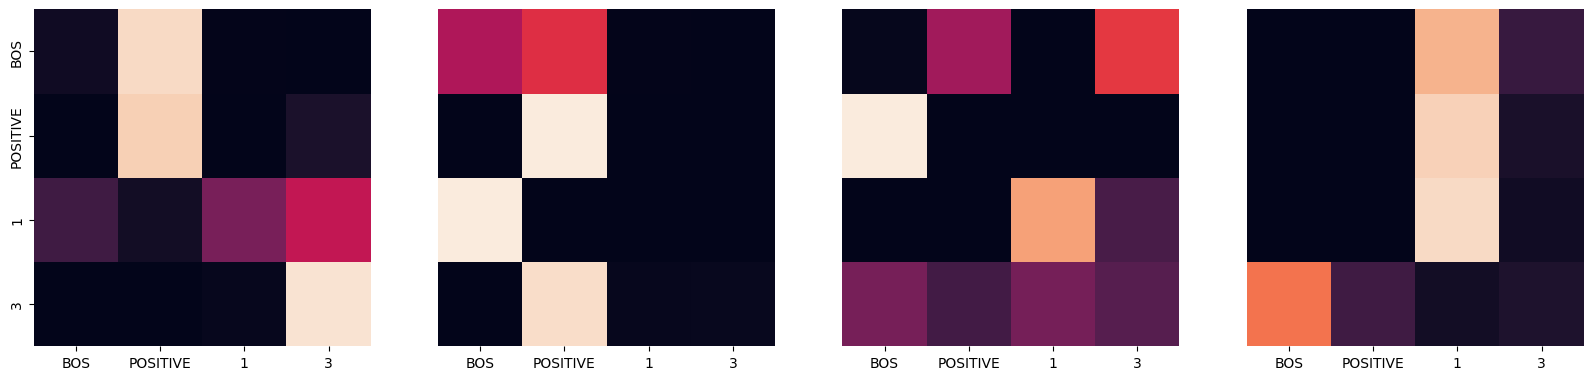

Decoder Cross attention 1


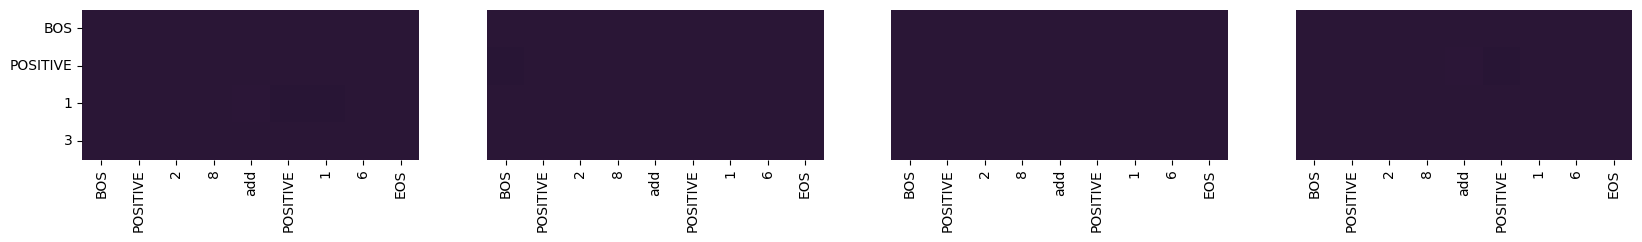

Decoder Block number  2
Decoder Self Attention 2


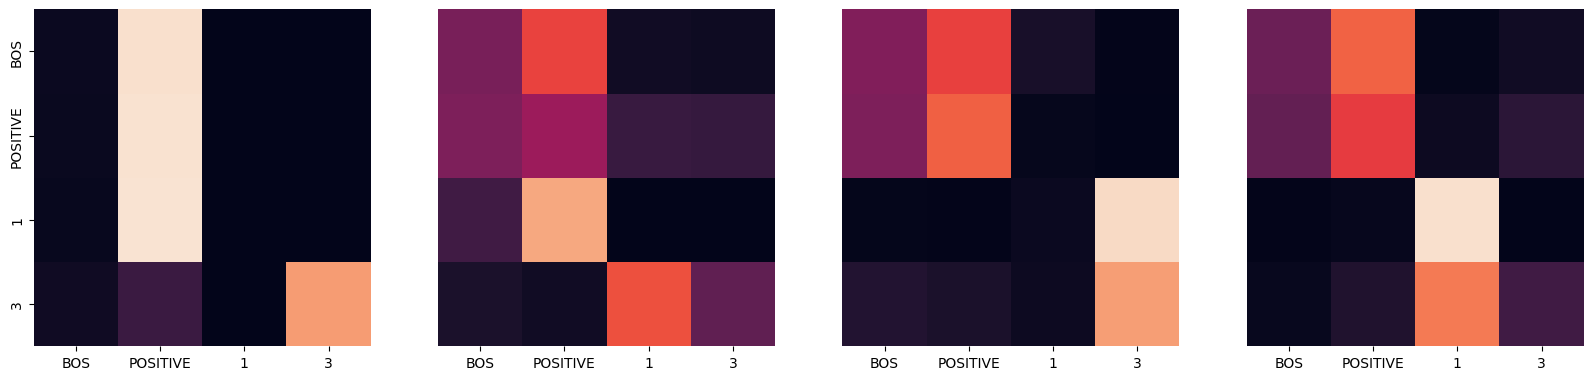

Decoder Cross attention 2


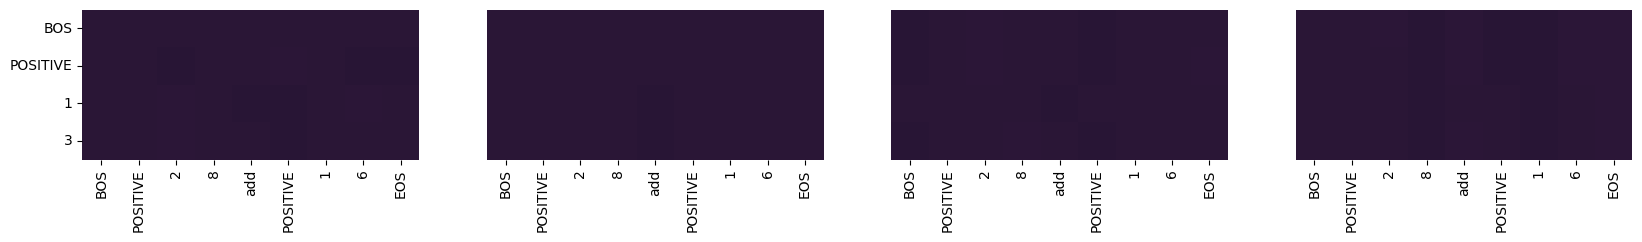

Decoder Block number  3
Decoder Self Attention 3


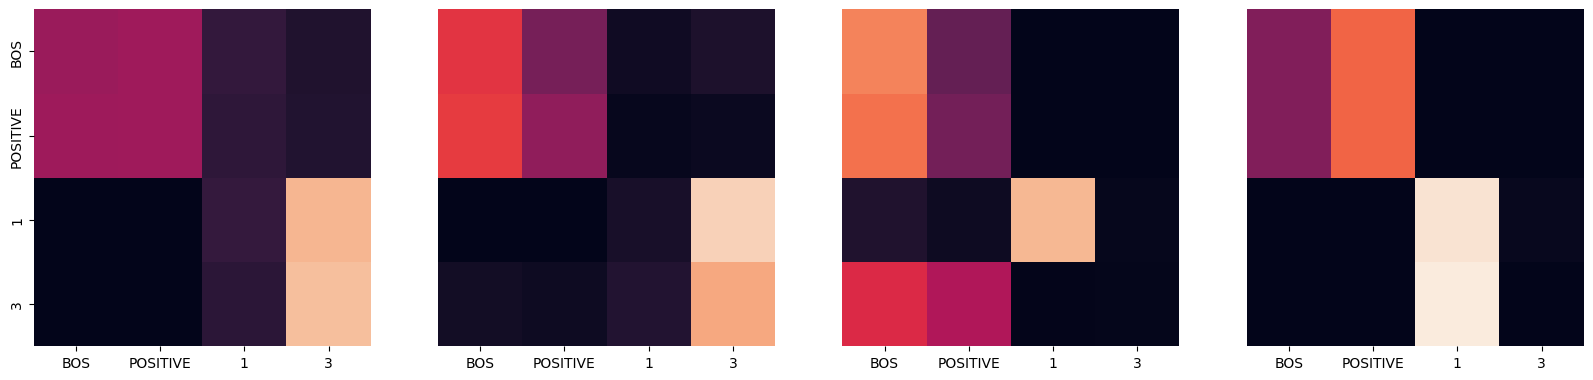

Decoder Cross attention 3


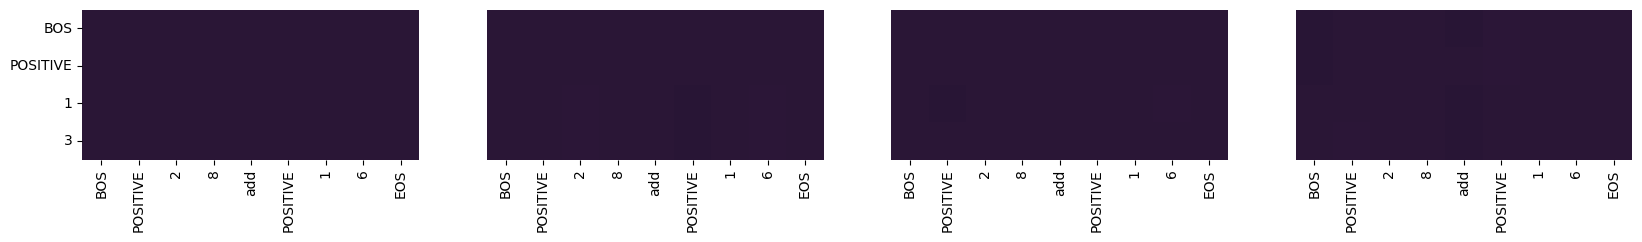

Decoder Block number  4
Decoder Self Attention 4


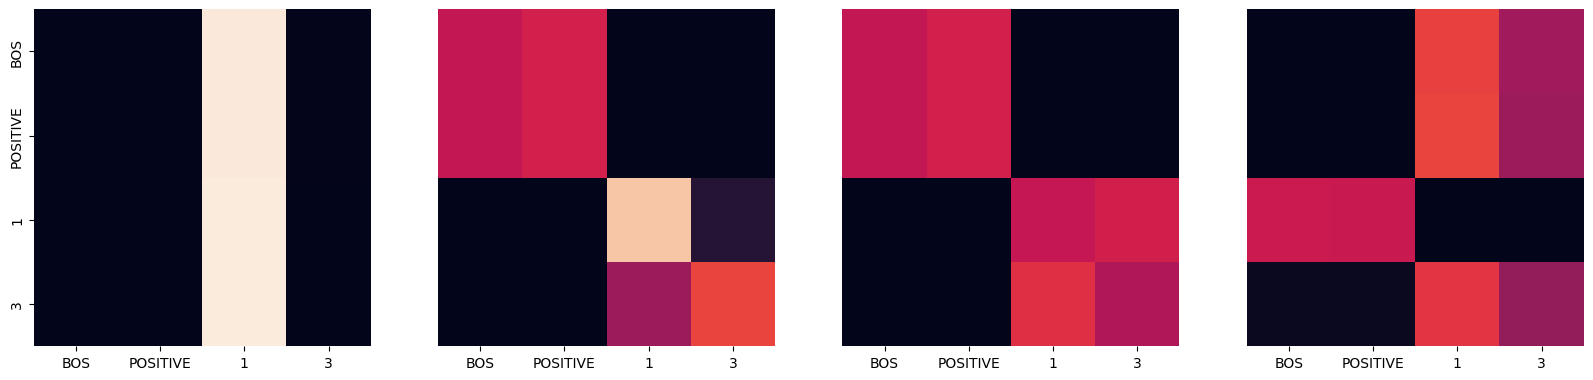

Decoder Cross attention 4


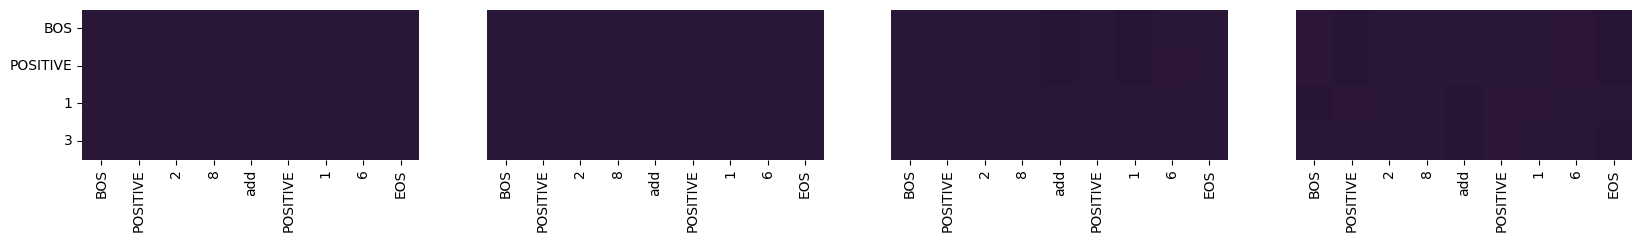

In [58]:
for layer in range(num_dec_layers):
    fig, axs = plt.subplots(1, num_heads, figsize=(20, 10))

    print("Decoder Block number ", layer + 1)

    print("Decoder Self Attention", layer + 1)
    for h in range(num_heads):
        draw(
            trained_model.decoder.layers[layer]
            .attention_self.heads[h]
            .weights_softmax.data.cpu()
            .numpy()[0],
            target_exp,
            target_exp if h == 0 else [],
            ax=axs[h],
        )
    plt.show()
    print("Decoder Cross attention", layer + 1)
    fig, axs = plt.subplots(1, 4, figsize=(20, 10))
    for h in range(num_heads):
        draw(
            trained_model.decoder.layers[layer]
            .attention_cross.heads[h]
            .weights_softmax.data.cpu()
            .numpy()[0],
            inp_seq,
            target_exp if h == 0 else [],
            ax=axs[h],
        )
    plt.show()

### 下面是调试的过程，可不再看 ###

In [ ]:
file = open("file2.txt", "w")
for emb_dim1 in [64]:
    train_data = AddSubDataset(X_train,y_train,convert_str_to_tokens,SPECIAL_TOKENS,emb_dim1,position_encoding_sinusoid,)
    valid_data = AddSubDataset(X_val,y_val,convert_str_to_tokens,SPECIAL_TOKENS,emb_dim1,position_encoding_sinusoid,)
    test_data = AddSubDataset(X_test,y_test,convert_str_to_tokens,SPECIAL_TOKENS,emb_dim1,position_encoding_sinusoid,)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
    valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
    for epoches1 in [80,90]:
        for num_heads1 in [16]:
            for lr1 in [1e-3]:
                for dim_feedforward1 in [16]:
                    for dropout1 in [0.1]:
                        line = "under lr {} epoches {} num_heads {} emb_dim {} dim_feedforward {} dropout {}\n".format(lr1, epoches1, num_heads1, emb_dim1, dim_feedforward1, dropout1)
                        file.write(line)
                        model1 = Transformer(num_heads1,emb_dim1,dim_feedforward1,dropout1,num_enc_layers,num_dec_layers,vocab_len,)
                        trained_model = train(model1,train_loader,valid_loader,loss_func,epoches1,lr=lr1,batch_size=BATCH_SIZE,warmup_interval=warmup_interval,device=DEVICE)
                        print("Final Model accuracy: ", "{:.2f}".format(val(trained_model, test_loader, CrossEntropyLoss, 4, device=DEVICE)[1]))
                        file.write("\n")
                        
                        
file.close()

In [49]:
file = open("file3.txt", "w")
for emb_dim1 in [128]:
    train_data = AddSubDataset(X_train,y_train,convert_str_to_tokens,SPECIAL_TOKENS,emb_dim1,position_encoding_sinusoid,)
    valid_data = AddSubDataset(X_val,y_val,convert_str_to_tokens,SPECIAL_TOKENS,emb_dim1,position_encoding_sinusoid,)
    test_data = AddSubDataset(X_test,y_test,convert_str_to_tokens,SPECIAL_TOKENS,emb_dim1,position_encoding_sinusoid,)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
    valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
    for epoches1 in [90]:
        for num_heads1 in [32]:
            for lr1 in [5e-4]:
                for dim_feedforward1 in [32]:
                    for dropout1 in [0.1]:
                        line = "under lr {} epoches {} num_heads {} emb_dim {} dim_feedforward {} dropout {}\n".format(lr1, epoches1, num_heads1, emb_dim1, dim_feedforward1, dropout1)
                        file.write(line)
                        model1 = Transformer(num_heads1,emb_dim1,dim_feedforward1,dropout1,num_enc_layers,num_dec_layers,vocab_len,)
                        trained_model = train(model1,train_loader,valid_loader,loss_func,epoches1,lr=lr1,batch_size=BATCH_SIZE,warmup_interval=warmup_interval,device=DEVICE)
                        print("Final Model accuracy: ", "{:.2f}".format(val(trained_model, test_loader, CrossEntropyLoss, 4, device=DEVICE)[1]))
                        file.write("\n")
                        
                        
file.close()

Training started...
[epoch: 1] [loss:  2.6774 ] [train_acc:  0.1935 ] [val_acc:  0.2500 ] val_loss: [val_loss  2.3160 ]
[epoch: 2] [loss:  2.3888 ] [train_acc:  0.2650 ] [val_acc:  0.4248 ] val_loss: [val_loss  2.0872 ]
[epoch: 3] [loss:  1.9828 ] [train_acc:  0.4155 ] [val_acc:  0.4932 ] val_loss: [val_loss  1.5565 ]
[epoch: 4] [loss:  1.5624 ] [train_acc:  0.4798 ] [val_acc:  0.5166 ] val_loss: [val_loss  1.2542 ]
[epoch: 5] [loss:  1.3526 ] [train_acc:  0.5044 ] [val_acc:  0.5127 ] val_loss: [val_loss  1.2194 ]
[epoch: 6] [loss:  1.2973 ] [train_acc:  0.5106 ] [val_acc:  0.5361 ] val_loss: [val_loss  1.2054 ]
[epoch: 7] [loss:  1.2554 ] [train_acc:  0.5288 ] [val_acc:  0.5391 ] val_loss: [val_loss  1.1780 ]
[epoch: 8] [loss:  1.2305 ] [train_acc:  0.5421 ] [val_acc:  0.5771 ] val_loss: [val_loss  1.1393 ]
[epoch: 9] [loss:  1.1897 ] [train_acc:  0.5570 ] [val_acc:  0.5879 ] val_loss: [val_loss  1.0954 ]
[epoch: 10] [loss:  1.1460 ] [train_acc:  0.5734 ] [val_acc:  0.6025 ] val_loss:

In [46]:
file = open("file2.txt", "w")
for emb_dim1 in [64]:
    train_data = AddSubDataset(X_train,y_train,convert_str_to_tokens,SPECIAL_TOKENS,emb_dim1,position_encoding_sinusoid,)
    valid_data = AddSubDataset(X_val,y_val,convert_str_to_tokens,SPECIAL_TOKENS,emb_dim1,position_encoding_sinusoid,)
    test_data = AddSubDataset(X_test,y_test,convert_str_to_tokens,SPECIAL_TOKENS,emb_dim1,position_encoding_sinusoid,)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
    valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
    for epoches1 in [80,90]:
        for num_heads1 in [16]:
            for lr1 in [1e-3]:
                for dim_feedforward1 in [16]:
                    for dropout1 in [0.1]:
                        line = "under lr {} epoches {} num_heads {} emb_dim {} dim_feedforward {} dropout {}\n".format(lr1, epoches1, num_heads1, emb_dim1, dim_feedforward1, dropout1)
                        file.write(line)
                        model1 = Transformer(num_heads1,emb_dim1,dim_feedforward1,dropout1,num_enc_layers,num_dec_layers,vocab_len,)
                        trained_model = train(model1,train_loader,valid_loader,loss_func,epoches1,lr=lr1,batch_size=BATCH_SIZE,warmup_interval=warmup_interval,device=DEVICE)
                        print("Final Model accuracy: ", "{:.2f}".format(val(trained_model, test_loader, CrossEntropyLoss, 4, device=DEVICE)[1]))
                        file.write("\n")
                        
                        
file.close()

Training started...
[epoch: 1] [loss:  2.5659 ] [train_acc:  0.2152 ] [val_acc:  0.4180 ] val_loss: [val_loss  2.1916 ]
[epoch: 2] [loss:  2.0603 ] [train_acc:  0.3596 ] [val_acc:  0.4365 ] val_loss: [val_loss  1.6439 ]
[epoch: 3] [loss:  1.6604 ] [train_acc:  0.4322 ] [val_acc:  0.4932 ] val_loss: [val_loss  1.3247 ]
[epoch: 4] [loss:  1.4027 ] [train_acc:  0.4757 ] [val_acc:  0.5127 ] val_loss: [val_loss  1.2656 ]
[epoch: 5] [loss:  1.3394 ] [train_acc:  0.5005 ] [val_acc:  0.5244 ] val_loss: [val_loss  1.2433 ]
[epoch: 6] [loss:  1.2817 ] [train_acc:  0.5126 ] [val_acc:  0.5322 ] val_loss: [val_loss  1.1955 ]
[epoch: 7] [loss:  1.2549 ] [train_acc:  0.5238 ] [val_acc:  0.5469 ] val_loss: [val_loss  1.1664 ]
[epoch: 8] [loss:  1.2251 ] [train_acc:  0.5424 ] [val_acc:  0.5654 ] val_loss: [val_loss  1.1460 ]
[epoch: 9] [loss:  1.1915 ] [train_acc:  0.5519 ] [val_acc:  0.5693 ] val_loss: [val_loss  1.1388 ]
[epoch: 10] [loss:  1.1685 ] [train_acc:  0.5643 ] [val_acc:  0.6035 ] val_loss:

In [45]:
file = open("file.txt", "w")
for emb_dim1 in [32,64]:
    train_data = AddSubDataset(X_train,y_train,convert_str_to_tokens,SPECIAL_TOKENS,emb_dim1,position_encoding_sinusoid,)
    valid_data = AddSubDataset(X_val,y_val,convert_str_to_tokens,SPECIAL_TOKENS,emb_dim1,position_encoding_sinusoid,)
    test_data = AddSubDataset(X_test,y_test,convert_str_to_tokens,SPECIAL_TOKENS,emb_dim1,position_encoding_sinusoid,)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
    valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
    for epoches1 in [60,70]:
        for num_heads1 in [16]:
            for lr1 in [1e-3]:
                for dim_feedforward1 in [16]:
                    for dropout1 in [0.1]:
                        line = "under lr {} epoches {} num_heads {} emb_dim {} dim_feedforward {} dropout {}\n".format(lr1, epoches1, num_heads1, emb_dim1, dim_feedforward1, dropout1)
                        file.write(line)
                        model1 = Transformer(num_heads1,emb_dim1,dim_feedforward1,dropout1,num_enc_layers,num_dec_layers,vocab_len,)
                        trained_model = train(model1,train_loader,valid_loader,loss_func,epoches1,lr=lr1,batch_size=BATCH_SIZE,warmup_interval=warmup_interval,device=DEVICE)
                        print("Final Model accuracy: ", "{:.2f}".format(val(trained_model, test_loader, CrossEntropyLoss, 4, device=DEVICE)[1]))
                        file.write("\n")
                        
                        
file.close()

Training started...
[epoch: 1] [loss:  2.8846 ] [train_acc:  0.1698 ] [val_acc:  0.2500 ] val_loss: [val_loss  2.4457 ]
[epoch: 2] [loss:  2.5264 ] [train_acc:  0.2073 ] [val_acc:  0.2500 ] val_loss: [val_loss  2.3827 ]
[epoch: 3] [loss:  2.4529 ] [train_acc:  0.2217 ] [val_acc:  0.2500 ] val_loss: [val_loss  2.3362 ]
[epoch: 4] [loss:  2.3890 ] [train_acc:  0.2532 ] [val_acc:  0.3672 ] val_loss: [val_loss  2.1835 ]
[epoch: 5] [loss:  2.1777 ] [train_acc:  0.3542 ] [val_acc:  0.4785 ] val_loss: [val_loss  1.7716 ]
[epoch: 6] [loss:  1.8110 ] [train_acc:  0.4305 ] [val_acc:  0.5059 ] val_loss: [val_loss  1.4168 ]
[epoch: 7] [loss:  1.5086 ] [train_acc:  0.4729 ] [val_acc:  0.5049 ] val_loss: [val_loss  1.3177 ]
[epoch: 8] [loss:  1.4018 ] [train_acc:  0.4948 ] [val_acc:  0.5166 ] val_loss: [val_loss  1.2762 ]
[epoch: 9] [loss:  1.3463 ] [train_acc:  0.5077 ] [val_acc:  0.5244 ] val_loss: [val_loss  1.2480 ]
[epoch: 10] [loss:  1.3148 ] [train_acc:  0.5124 ] [val_acc:  0.5303 ] val_loss:

In [34]:
file = open("file.txt", "w")
for emb_dim1 in [16,32]:
    train_data = AddSubDataset(X_train,y_train,convert_str_to_tokens,SPECIAL_TOKENS,emb_dim1,position_encoding_sinusoid,)
    valid_data = AddSubDataset(X_val,y_val,convert_str_to_tokens,SPECIAL_TOKENS,emb_dim1,position_encoding_sinusoid,)
    test_data = AddSubDataset(X_test,y_test,convert_str_to_tokens,SPECIAL_TOKENS,emb_dim1,position_encoding_sinusoid,)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
    valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
    for epoches1 in [40,50]:
        for num_heads1 in [16]:
            for lr1 in [1e-2,1e-3]:
                for dim_feedforward1 in [16]:
                    for dropout1 in [0.1]:
                        line = "under lr {} epoches {} num_heads {} emb_dim {} dim_feedforward {} dropout {}\n".format(lr1, epoches1, num_heads1, emb_dim1, dim_feedforward1, dropout1)
                        file.write(line)
                        model1 = Transformer(num_heads1,emb_dim1,dim_feedforward1,dropout1,num_enc_layers,num_dec_layers,vocab_len,)
                        trained_model = train(model1,train_loader,valid_loader,loss_func,epoches1,lr=lr1,batch_size=BATCH_SIZE,warmup_interval=warmup_interval,device=DEVICE)
                        print("Final Model accuracy: ", "{:.2f}".format(val(trained_model, test_loader, CrossEntropyLoss, 4, device=DEVICE)[1]))
                        file.write("\n")
                        
                        
file.close()

Training started...
[epoch: 1] [loss:  2.5081 ] [train_acc:  0.2213 ] [val_acc:  0.2500 ] val_loss: [val_loss  2.3480 ]
[epoch: 2] [loss:  2.2919 ] [train_acc:  0.2895 ] [val_acc:  0.3643 ] val_loss: [val_loss  2.0380 ]
[epoch: 3] [loss:  1.9818 ] [train_acc:  0.3796 ] [val_acc:  0.3916 ] val_loss: [val_loss  1.7303 ]
[epoch: 4] [loss:  1.6869 ] [train_acc:  0.4101 ] [val_acc:  0.4229 ] val_loss: [val_loss  1.4848 ]
[epoch: 5] [loss:  1.4320 ] [train_acc:  0.4299 ] [val_acc:  0.4238 ] val_loss: [val_loss  1.3187 ]
[epoch: 6] [loss:  1.3261 ] [train_acc:  0.4443 ] [val_acc:  0.4238 ] val_loss: [val_loss  1.3090 ]
[epoch: 7] [loss:  1.3244 ] [train_acc:  0.4410 ] [val_acc:  0.4297 ] val_loss: [val_loss  1.3047 ]
[epoch: 8] [loss:  1.3219 ] [train_acc:  0.4395 ] [val_acc:  0.4297 ] val_loss: [val_loss  1.3044 ]
[epoch: 9] [loss:  1.3135 ] [train_acc:  0.4406 ] [val_acc:  0.4346 ] val_loss: [val_loss  1.3001 ]
[epoch: 10] [loss:  1.3042 ] [train_acc:  0.4432 ] [val_acc:  0.4346 ] val_loss:

In [35]:
# # model.load_state_dict(torch.load()))
# # model.to(DEVICE)
# trained_model = train(
#     model,
#     train_loader,
#     valid_loader,
#     loss_func,
#     num_epochs,
#     lr = lr,
#     batch_size=BATCH_SIZE,
#     warmup_interval=warmup_interval,
#     device=DEVICE
# )
# weights_path = os.path.join('/kaggle/working/', "transformer.pt")
# torch.save(trained_model.state_dict(), weights_path)

In [ ]:
#Final test accuracy
print(
    "Final Model accuracy: ",
    "{:.2f}".format(
        val(
            trained_model, test_loader, CrossEntropyLoss, 4, device=DEVICE
        )[1]
    ),
)

# model.load_state_dict(torch.load(weights_path))
# model.to(DEVICE)

请自行调节模型训练的超参数、优化器等，使得模型在测试集上的准确率尽可能高。

分段给分（计分时准确率四舍五入保留到小数点后2位，例如0.623计为0.62）：

| Baseline  | Accuracy        | Score  |
| :---:     |    :----:       |  :---: |
| Vallina   | \[0.50, 0.63\]  |   12   |
| Simple    | [0.63, 0.70\)   |   14   |
| Medium    | [0.70, 0.74\)   |   16   |
| Hard      | [0.74, 0.80\)   |   20   |
| Strong    | [0.80, 1.00\)   |   25   |

## 可视化与推断：模型展示

既然我们已经训练了一个模型，让我们来看看最终的结果。我们将首先查看来自验证数据的结果，并可视化注意力权重（记住self.weights_softmax吗？）。这些注意力权重应该让你对网络学习到了什么有一些直觉。我们已经为您实现了所有内容，意图是帮助您探索模型并了解网络学习到了什么。

In [36]:
def inference(model, inp_exp, inp_exp_pos, out_pos_exp, out_seq_len):
    model.eval()
    y_init = torch.LongTensor([14]).unsqueeze(0).cuda().view(1, 1)

    ques_emb = model.emb_layer(inp_exp)
    q_emb_inp = ques_emb + inp_exp_pos
    enc_out = model.encoder(q_emb_inp)
    for i in range(out_seq_len - 1):
        ans_emb = model.emb_layer(y_init)
        a_emb_inp = ans_emb + out_pos_exp[:, : y_init.shape[1], :]
        dec_out = model.decoder(a_emb_inp, enc_out, None)
        _, next_word = torch.max(
            dec_out[0, y_init.shape[1] - 1 : y_init.shape[1]], dim=1
        )

        y_init = torch.cat([y_init, next_word.view(1, 1)], dim=1)
    return y_init, model

### 验证数据的结果

在下面的单元格中，我们选择验证数据中的第一个数据点，并找到其结果。

In [37]:
for it in valid_loader:
    it
    break
inp, inp_pos, out, out_pos = it
opposite_tokens_to_str = {v: k for k, v in convert_str_to_tokens.items()}
device = torch.device("cuda")
model = model.to(device)
inp_pos = inp_pos.to(device)
out_pos = out_pos.to(device)
out = out.to(device)
inp = inp.to(device)

inp_exp = inp[:1, :]
inp_exp_pos = inp_pos[:1]
out_pos_exp = out_pos[:1, :]
inp_seq = [opposite_tokens_to_str[w.item()] for w in inp_exp[0]]
print(
    "Input sequence: \n",
    inp_seq[0]
    + " "
    + inp_seq[1]
    + " "
    + inp_seq[2]
    + inp_seq[3]
    + " "
    + inp_seq[4]
    + " "
    + inp_seq[5]
    + " "
    + inp_seq[6]
    + inp_seq[7]
    + " "
    + inp_seq[8],
)

Input sequence: 
 BOS POSITIVE 28 add POSITIVE 16 EOS


In [38]:
out_seq_ans, _ = inference(
    trained_model, inp_exp, inp_exp_pos, out_pos_exp, out_seq_len
)

trained_model.eval()

print("Output Sequence:", end="\t")
res = "BOS "
for i in range(1, out_seq_ans.size(1)):
    sym = opposite_tokens_to_str[out_seq_ans[0, i].item()]
    if sym == "EOS":
        break
    res += sym + " " 
print(res)

Output Sequence:	BOS POSITIVE 4 4 


### 选择您自己的探索示例

在下面的单元格中，您可以输入一个示例到输入样式中，更改变量 `custom_seq`。我们已经为您填写了一个占位表达式，但随意更改它。

In [39]:
custom_seq = "BOS POSITIVE 02 subtract NEGATIVE 07 EOS"

In [40]:
out = prepocess_input_sequence(custom_seq, convert_str_to_tokens, SPECIAL_TOKENS)
inp_exp = torch.tensor(out).to(DEVICE)

out_seq_ans, model_for_visv = inference(
    trained_model, inp_exp, inp_exp_pos, out_pos_exp, out_seq_len
)

trained_model.eval()

print("Output Sequence:", end="\t")
res = "BOS "
for i in range(1, out_seq_ans.size(1)):
    sym = opposite_tokens_to_str[out_seq_ans[0, i].item()]
    if sym == "EOS":
        break
    res += sym + " "
print(res)

Output Sequence:	BOS POSITIVE 1 3 


### 可视化注意力权重

在这部分中，我们将为您输入的特定自定义输入可视化注意力权重。编码器和解码器有单独的热图。颜色中的较浅值显示了该行和列中存在的令牌之间的较高关联，而较暗的颜色则显示它们之间的关系较弱。

In [41]:
def draw(data, x, y, ax):
    seaborn.heatmap(
        data,
        xticklabels=x,
        square=True,
        yticklabels=y,
        vmin=0.0,
        vmax=1.0,
        cbar=False,
        ax=ax,
    )

In [42]:
target_exp = res.split()

Encoder Block Number 1


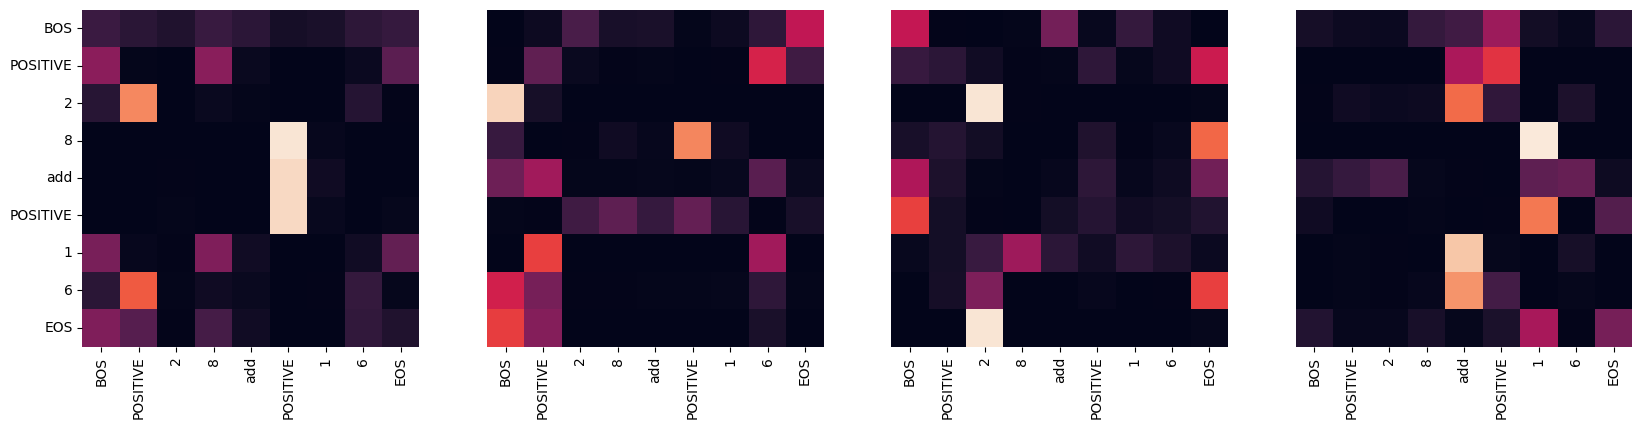

Encoder Block Number 2


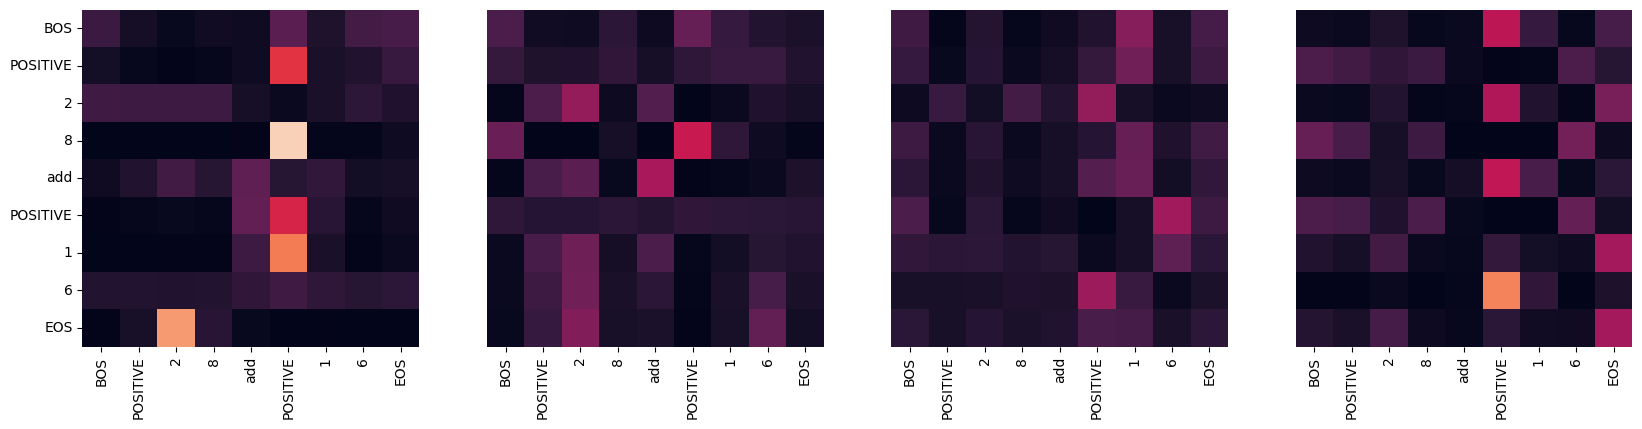

Encoder Block Number 3


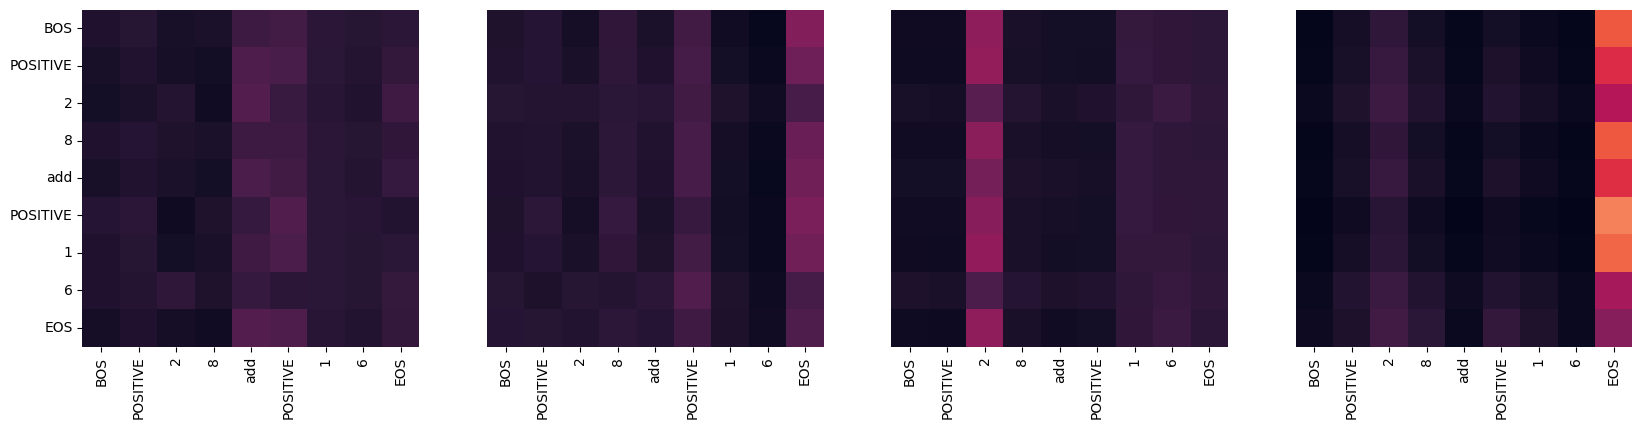

Encoder Block Number 4


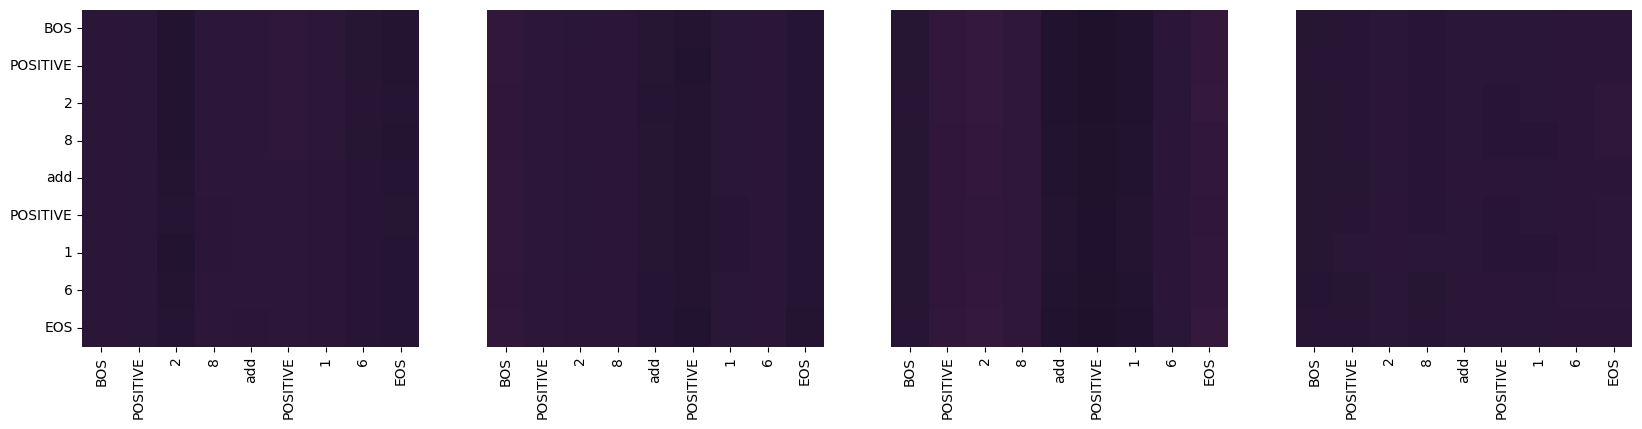

In [43]:
for layer in range(num_enc_layers):
    fig, axs = plt.subplots(1, num_heads, figsize=(20, 10))
    print("Encoder Block Number", layer + 1)
    for h in range(num_heads):
        draw(
            trained_model.encoder.layers[layer]
            .multihead_attention.heads[h]
            .weights_softmax.data.cpu()
            .numpy()[0],
            inp_seq,
            inp_seq if h == 0 else [],
            ax=axs[h],
        )
    plt.show()
plt.close()


Decoder Block number  1
Decoder Self Attention 1


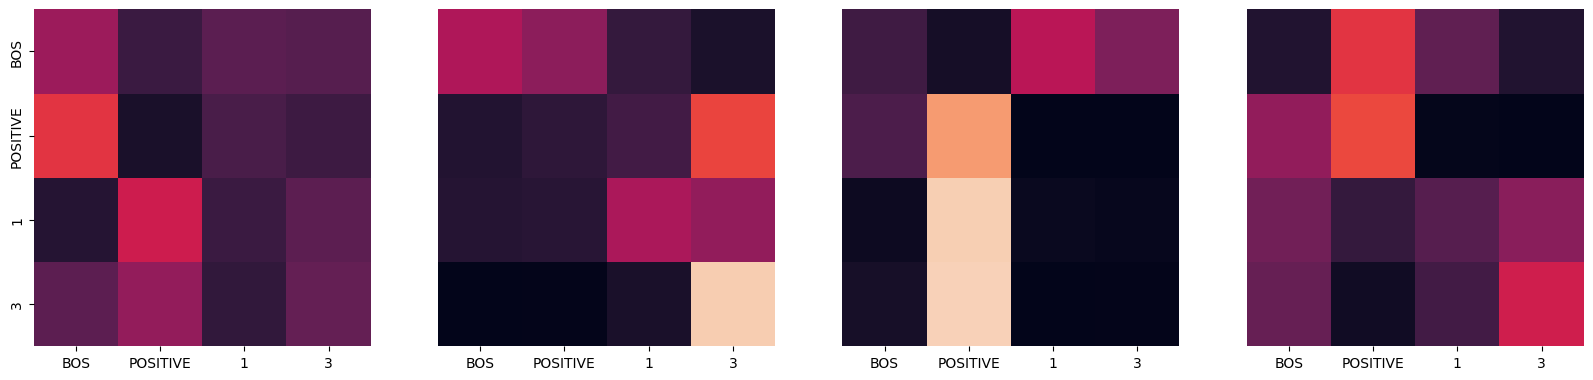

Decoder Cross attention 1


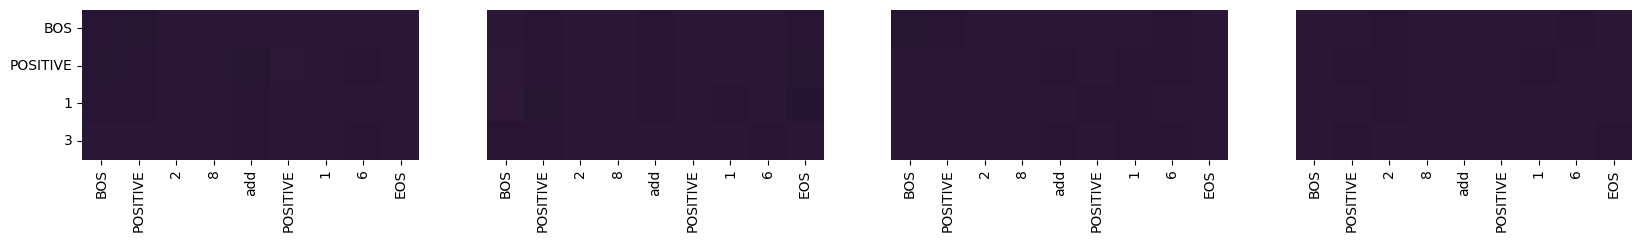

Decoder Block number  2
Decoder Self Attention 2


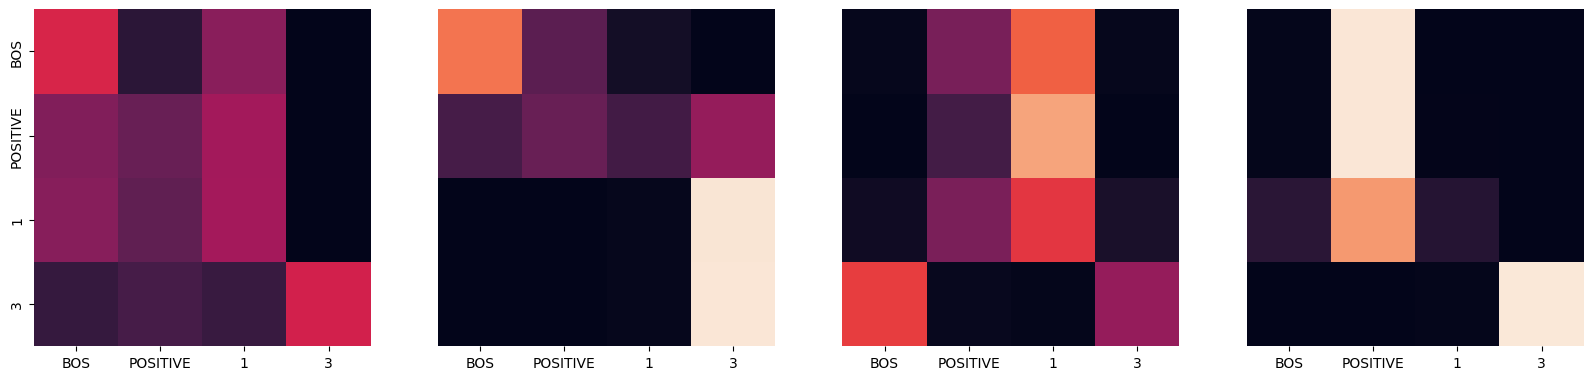

Decoder Cross attention 2


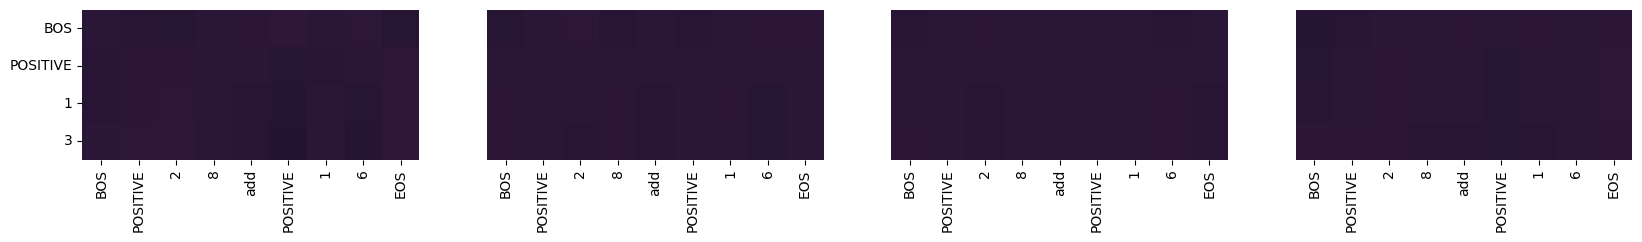

Decoder Block number  3
Decoder Self Attention 3


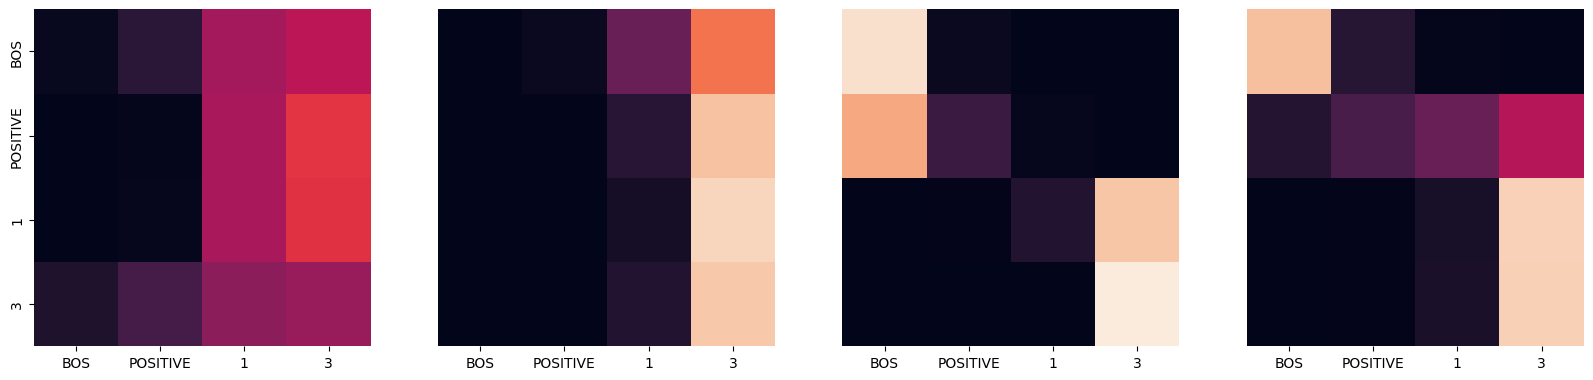

Decoder Cross attention 3


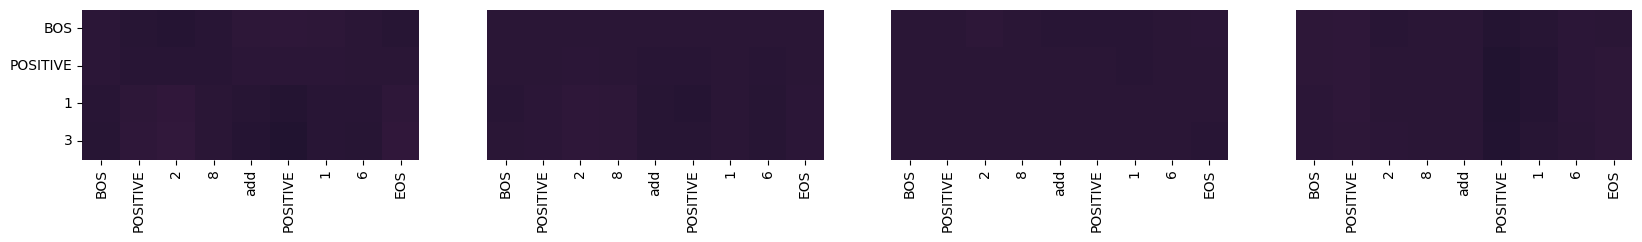

Decoder Block number  4
Decoder Self Attention 4


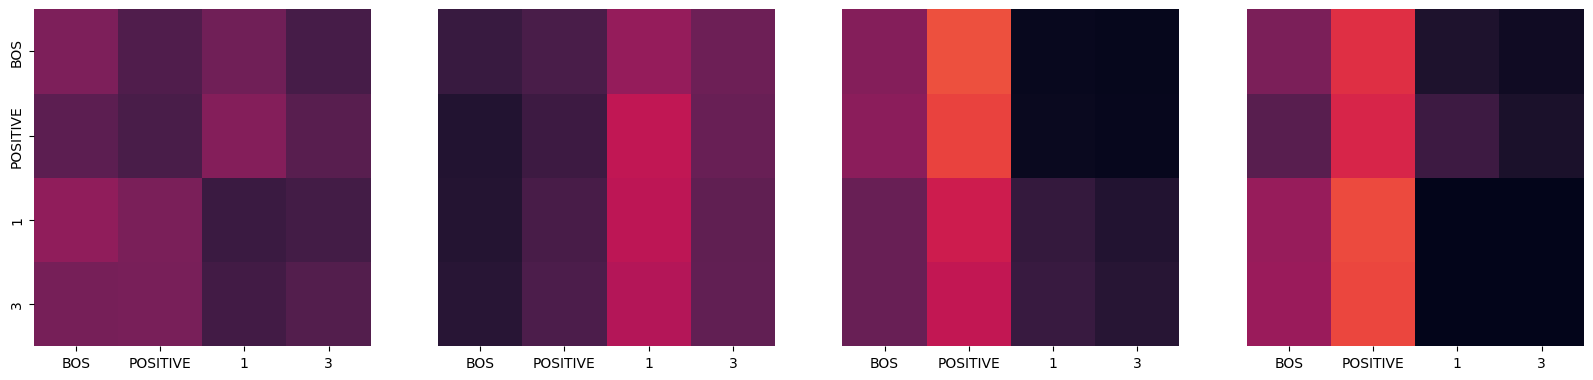

Decoder Cross attention 4


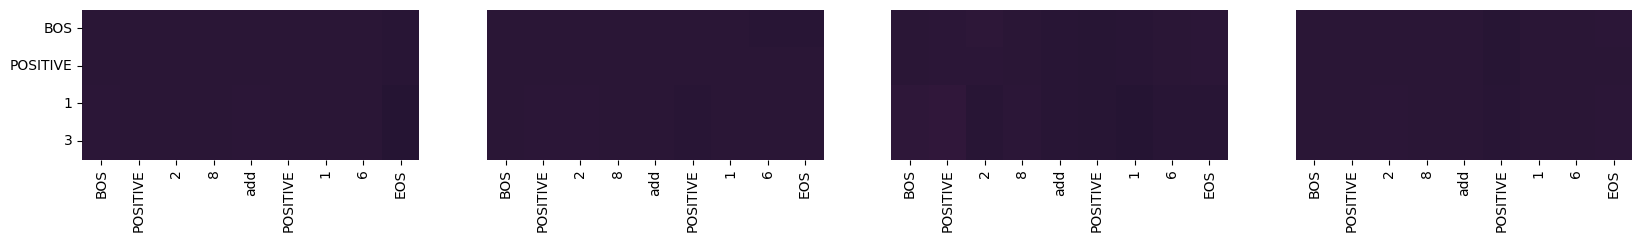

In [44]:
for layer in range(num_dec_layers):
    fig, axs = plt.subplots(1, num_heads, figsize=(20, 10))

    print("Decoder Block number ", layer + 1)

    print("Decoder Self Attention", layer + 1)
    for h in range(num_heads):
        draw(
            trained_model.decoder.layers[layer]
            .attention_self.heads[h]
            .weights_softmax.data.cpu()
            .numpy()[0],
            target_exp,
            target_exp if h == 0 else [],
            ax=axs[h],
        )
    plt.show()
    print("Decoder Cross attention", layer + 1)
    fig, axs = plt.subplots(1, 4, figsize=(20, 10))
    for h in range(num_heads):
        draw(
            trained_model.decoder.layers[layer]
            .attention_cross.heads[h]
            .weights_softmax.data.cpu()
            .numpy()[0],
            inp_seq,
            target_exp if h == 0 else [],
            ax=axs[h],
        )
    plt.show()